In [1]:
# libraries
import os
import io
from pathlib import Path
from datetime import timedelta
import warnings
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
 )
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

import joblib

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")

# 1-р хэсэг: Өгөгдөл ачаалах ба урьдчилсан боловсруулалт

In [2]:
EXCEL_PATH = "online_retail_II.xlsx" 
DOWNLOAD_URL = "https://archive.ics.uci.edu/static/public/502/online%2Bretail%2Bii.zip"
OUTPUT_CSV = "online_retail_cleaned.csv"

In [ ]:
def load_excel(path: str = EXCEL_PATH, download_url: str | None = None):
    """Онлайн жижиглэний өгөгдлийг Excel файлаас эсвэл татан авч унших."""
    if os.path.exists(path):
        print(f"local file path: {path}")
        xls = pd.read_excel(path, sheet_name=None)
        return xls
    elif download_url:
        try:
            print(f"Downloading from the internet: {download_url}")
            import requests
            response = requests.get(download_url, timeout=60)
            response.raise_for_status()

            #unzip file
            file = Path(path)
            with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                z.extractall(file.parent)


            xls = pd.read_excel(file, sheet_name=None)
            return xls
        except Exception as exc:
            raise RuntimeError(f"Error occurred while downloading or reading Excel file: {exc}") from exc
    else:
        raise FileNotFoundError(
            f"File not found locally and no download URL provided: {path}"
        )

In [4]:
# Өгөгдлийн бүх хуудсыг унших
sheets = load_excel(EXCEL_PATH, download_url=DOWNLOAD_URL)
print("Олдсон хүснэгтүүд:", list(sheets.keys()))

Олдсон хүснэгтүүд: ['Year 2009-2010', 'Year 2010-2011']
Олдсон хүснэгтүүд: ['Year 2009-2010', 'Year 2010-2011']


In [5]:
# Хоёр хуудасны өгөгдлийг нэг датафрэймд нэгтгэх
df_list = []
for sheet_name, sheet_df in sheets.items():
    sheet_df["__source_sheet"] = sheet_name
    df_list.append(sheet_df)

df = pd.concat(df_list, ignore_index=True)
print("\nНэгтгэсний дараах анхны хэмжээ:", df.shape)


Нэгтгэсний дараах анхны хэмжээ: (1067371, 9)


In [6]:
print("Өгөгдлийн мэдээллийн тойм:")
df.info()

Өгөгдлийн мэдээллийн тойм:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Invoice         1067371 non-null  object        
 1   StockCode       1067371 non-null  object        
 2   Description     1062989 non-null  object        
 3   Quantity        1067371 non-null  int64         
 4   InvoiceDate     1067371 non-null  datetime64[ns]
 5   Price           1067371 non-null  float64       
 6   Customer ID     824364 non-null   float64       
 7   Country         1067371 non-null  object        
 8   __source_sheet  1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 73.3+ MB


### Анхны ажиглалт
- `InvoiceDate` багана тэмдэгтийн төрөлтэй тул огноо руу хөрвүүлэх шаардлагатай.
- `Customer ID` баганаар харилцагчийг ялган ангилах тул хоосон мөрүүдийг устгана.
- `Quantity` болон `Price`-ийн гажуудал (сөрөг, тэг утгууд) нь захиалгын цуцлалттай холбоотой байж болзошгүй.
- Нийт борлуулалтын үнийг илэрхийлэх `Revenue` (эсвэл `Total`) баганыг шинээр тооцоолно.

In [7]:
# Өгөгдөл цэвэрлэх иж бүрэн алхамууд
# 1. Тэмдэгт мөрүүдийг цэвэрлэх
# 2. Огноог зөв хэлбэрт оруулах
# 3. Цуцлагдсан захиалгыг илрүүлж хасах
# 4. Харилцагчийн дугаар дутуу мөрүүдийг устгах
# 5. Тоо хэмжээ болон үнийг эерэг утгатай эсэхийг шалгах
# 6. Давхардсан мөрүүдийг арилгах
# 7. Нийт борлуулалтын үнийн багана шинээр үүсгэх
# 8. Төрлүүдийг стандартчилах
# 9. Үр дүнг нэгтгэн харуулах
str_cols = ["Description", "Country"]
for col in str_cols:
    if col in df.columns:
        df[col] = df[col].astype("string").str.strip()

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True, errors="coerce")
missing_dates = df["InvoiceDate"].isna().sum()
print(f"Огноо хөрвүүлэхэд алга болсон мөрүүд: {missing_dates}")

if "Invoice" not in df.columns:
    raise KeyError("'Invoice' багана олдсонгүй. Файлын бүтцийг шалгана уу.")
df["Invoice_str"] = df["Invoice"].astype(str)
df["is_cancelled"] = df["Invoice_str"].str.startswith("C")

initial_rows = len(df)

if "Customer ID" in df.columns:
    customer_col = "Customer ID"
elif "CustomerID" in df.columns:
    customer_col = "CustomerID"
else:
    raise KeyError("Харилцагчийн дугаарын багана олдсонгүй.")

missing_customers = df[customer_col].isna().sum()
print(f"Харилцагчийн дугаар дутуу мөрүүд: {missing_customers}")

numeric_cols = ["Quantity", "Price"]
for col in numeric_cols:
    if col not in df.columns:
        raise KeyError(f"Шаардлагатай '{col}' багана байхгүй байна.")

mask_positive_qty = df["Quantity"] > 0
mask_positive_price = df["Price"] > 0
mask_not_cancelled = ~df["is_cancelled"]
mask_has_customer = ~df[customer_col].isna()

cleaned_df = df[mask_positive_qty & mask_positive_price & mask_not_cancelled & mask_has_customer].copy()
removed_rows = initial_rows - len(cleaned_df)
print(f"Цэвэрлэгээний явцад нийт {removed_rows} мөрийг хаслаа.")

dup_cols = ["Invoice", "StockCode", "Description", "Quantity", "InvoiceDate", "Price", customer_col]
dup_cols = [c for c in dup_cols if c in cleaned_df.columns]
before_dedup = len(cleaned_df)
cleaned_df = cleaned_df.drop_duplicates(subset=dup_cols)
print(f"Давхардсан мөр: {before_dedup - len(cleaned_df)}")

cleaned_df["Revenue"] = cleaned_df["Quantity"] * cleaned_df["Price"]
cleaned_df[customer_col] = cleaned_df[customer_col].astype(int)
cleaned_df = cleaned_df.reset_index(drop=True)

print("\nЦэвэрлэгдсэн датафрэймийн тойм:")
print("Хэмжээ:", cleaned_df.shape)
print("Давтагдахгүй харилцагчдын тоо:", cleaned_df[customer_col].nunique())
print("Нийт борлуулалт (GBP):", round(cleaned_df["Revenue"].sum(), 2))

Огноо хөрвүүлэхэд алга болсон мөрүүд: 0
Харилцагчийн дугаар дутуу мөрүүд: 243007
Цэвэрлэгээний явцад нийт 261822 мөрийг хаслаа.
Харилцагчийн дугаар дутуу мөрүүд: 243007
Цэвэрлэгээний явцад нийт 261822 мөрийг хаслаа.
Давхардсан мөр: 26124

Цэвэрлэгдсэн датафрэймийн тойм:
Хэмжээ: (779425, 12)
Давтагдахгүй харилцагчдын тоо: 5878
Нийт борлуулалт (GBP): 17374804.27
Давхардсан мөр: 26124

Цэвэрлэгдсэн датафрэймийн тойм:
Хэмжээ: (779425, 12)
Давтагдахгүй харилцагчдын тоо: 5878
Нийт борлуулалт (GBP): 17374804.27


# 2-р хэсэг: Судалгааны шинжилгээ (EDA)

In [8]:
# Борлуулалтын үндсэн үзүүлэлтүүдийг тооцоолох
order_count = cleaned_df["Invoice"].nunique()
customer_count = cleaned_df["Customer ID"].nunique()
product_count = cleaned_df["StockCode"].nunique()
total_revenue = cleaned_df["Revenue"].sum()
avg_order_value = cleaned_df.groupby("Invoice")["Revenue"].sum().mean()

print("Нийт захиалгын тоо:", order_count)
print("Нийт харилцагчдын тоо:", customer_count)
print("Нийт бүтээгдэхүүний төрөл:", product_count)
print("Нийт борлуулалтын орлого (GBP):", round(total_revenue, 2))
print("Нэг захиалгын дундаж үнэ (GBP):", round(avg_order_value, 2))

Нийт захиалгын тоо: 36969
Нийт харилцагчдын тоо: 5878
Нийт бүтээгдэхүүний төрөл: 4631
Нийт борлуулалтын орлого (GBP): 17374804.27
Нэг захиалгын дундаж үнэ (GBP): 469.98


## RFM шинжилгээ (Recency, Frequency, Monetary)

In [9]:
# Харилцагч тус бүрийн RFM үзүүлэлтийг тооцоолох
reference_date = cleaned_df["InvoiceDate"].max() + pd.Timedelta(days=1)
rfm_df = (
    cleaned_df.groupby("Customer ID").agg(
        recency=("InvoiceDate", lambda x: (reference_date - x.max()).days),
        frequency=("Invoice", "nunique"),
        monetary=("Revenue", "sum"),
    )
    .reset_index()
)
rfm_summary = rfm_df[["recency", "frequency", "monetary"]].describe(percentiles=[0.25, 0.5, 0.75]).round(2)
rfm_df = rfm_df.sort_values("recency")
print("RFM үзүүлэлтийн статистик тойм:")
display(rfm_summary)
print("\nRecency хамгийн бага (хамгийн идэвхтэй) 5 харилцагч:")
display(rfm_df.head(5))

RFM үзүүлэлтийн статистик тойм:


,recency,frequency,monetary
count,5878.00,5878.00,5878.00
mean,201.33,6.29,2955.90
std,209.34,13.01,14440.85
min,1.00,1.00,2.95
25%,26.00,1.00,342.28
50%,96.00,3.00,867.74
75%,380.00,7.00,2248.30
max,739.00,398.00,580987.04



Recency хамгийн бага (хамгийн идэвхтэй) 5 харилцагч:


,Customer ID,recency,frequency,monetary
4606,17001,1,19,6640.80
2780,15156,1,3,961.49
86,12433,1,10,16794.14
1526,13890,1,14,2927.38
945,13298,1,1,360.00


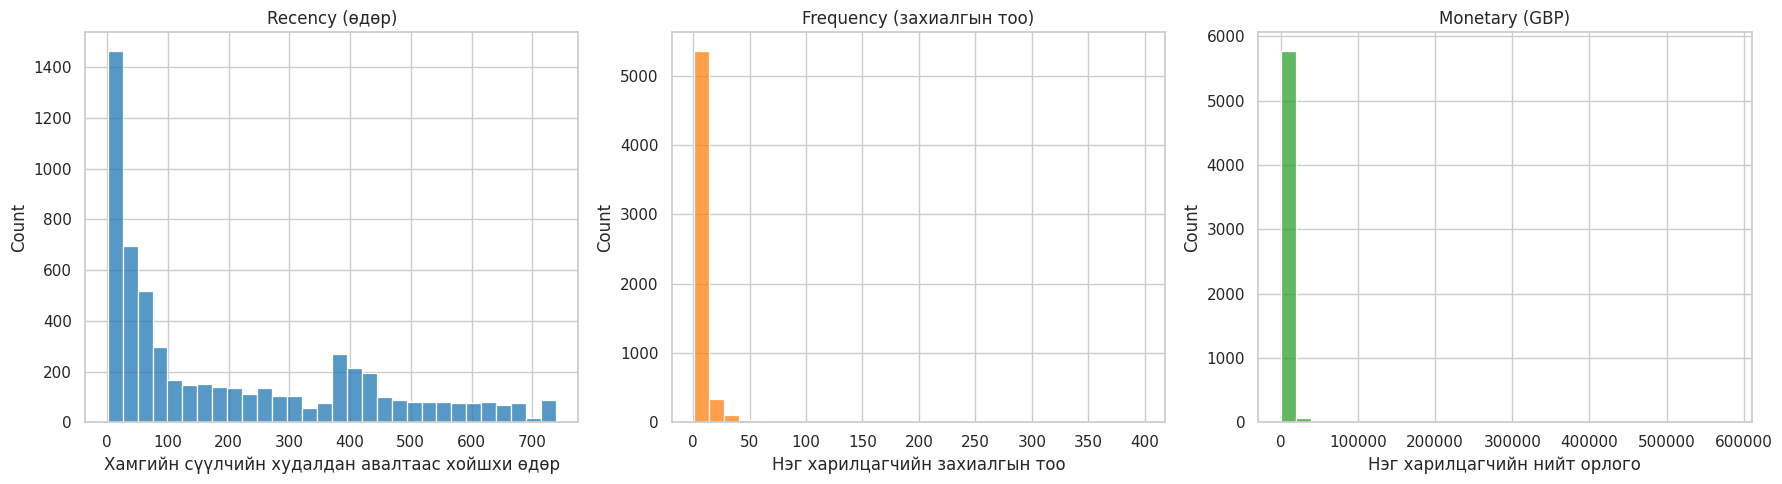

In [10]:
output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm_df["recency"], bins=30, ax=axes[0], color="#1f77b4")
axes[0].set_title("Recency (өдөр)")
axes[0].set_xlabel("Хамгийн сүүлчийн худалдан авалтаас хойшхи өдөр")

sns.histplot(rfm_df["frequency"], bins=30, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Frequency (захиалгын тоо)")
axes[1].set_xlabel("Нэг харилцагчийн захиалгын тоо")

sns.histplot(rfm_df["monetary"], bins=30, ax=axes[2], color="#2ca02c")
axes[2].set_title("Monetary (GBP)")
axes[2].set_xlabel("Нэг харилцагчийн нийт орлого")

plt.tight_layout()
fig.savefig(output_dir / "rfm_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

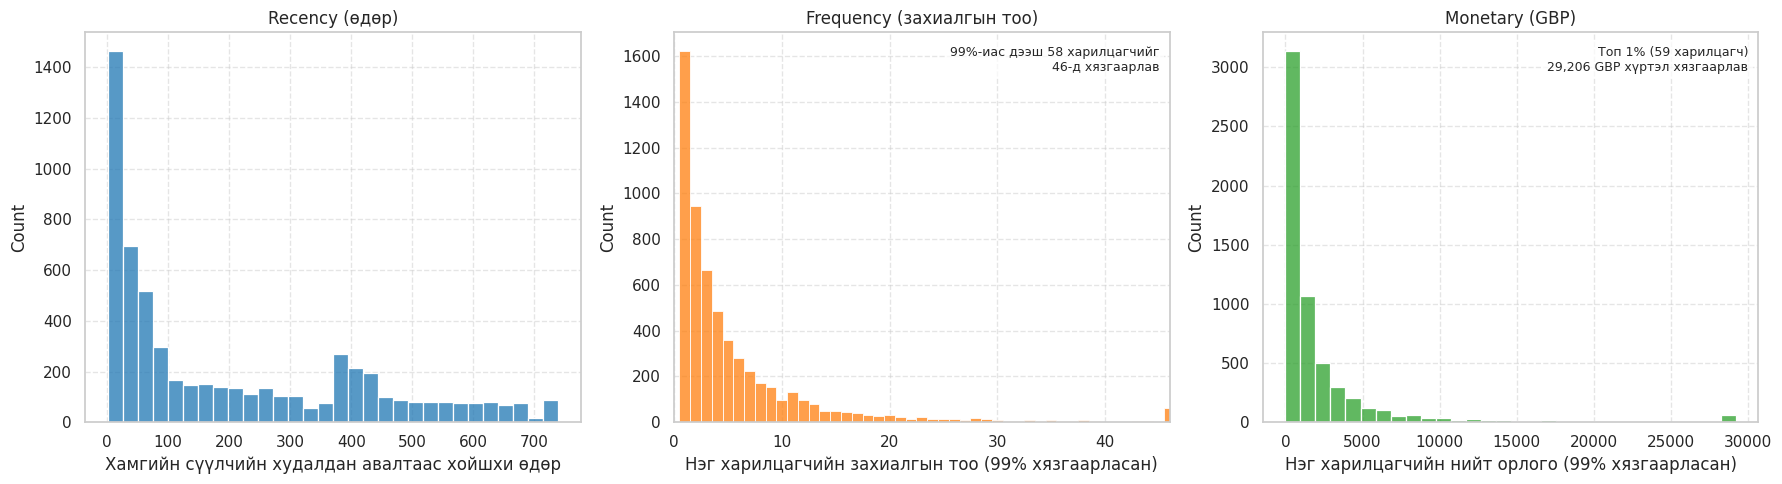

In [11]:
output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
sns.histplot(rfm_df["recency"], bins=30, ax=axes[0], color="#1f77b4")
axes[0].set_title("Recency (өдөр)")
axes[0].set_xlabel("Хамгийн сүүлчийн худалдан авалтаас хойшхи өдөр")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Frequency — discrete binning, cap at 99-р перцентиль
freq_series = rfm_df["frequency"].dropna()
freq_p99 = freq_series.quantile(0.99)
freq_clipped = freq_series.clip(upper=freq_p99).astype(int)
sns.histplot(freq_clipped, binwidth=1, ax=axes[1], color="#ff7f0e", discrete=True)
axes[1].set_title("Frequency (захиалгын тоо)")
axes[1].set_xlabel("Нэг харилцагчийн захиалгын тоо (99% хязгаарласан)")
axes[1].set_xlim(0, max(freq_clipped.max(), 5))
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].annotate(
    f"99%-иас дээш {int((freq_series > freq_p99).sum())} харилцагчийг\n{freq_p99:.0f}-д хязгаарлав",
    xy=(0.98, 0.9), xycoords="axes fraction", ha="right", fontsize=9,
    bbox=dict(boxstyle="round", fc="white", alpha=0.7)
    )

# Monetary — cap at 99-р перцентиль
monetary_series = rfm_df["monetary"].dropna()
monetary_p99 = monetary_series.quantile(0.99)
monetary_clipped = monetary_series.clip(upper=monetary_p99)
sns.histplot(monetary_clipped, bins=30, ax=axes[2], color="#2ca02c")
axes[2].set_title("Monetary (GBP)")
axes[2].set_xlabel("Нэг харилцагчийн нийт орлого (99% хязгаарласан)")
axes[2].grid(True, linestyle="--", alpha=0.5)
axes[2].annotate(
    f"Топ 1% ({int((monetary_series > monetary_p99).sum())} харилцагч)\n{monetary_p99:,.0f} GBP хүртэл хязгаарлав",
    xy=(0.98, 0.9), xycoords="axes fraction", ha="right", fontsize=9,
    bbox=dict(boxstyle="round", fc="white", alpha=0.7)
    )

plt.tight_layout()
fig.savefig(output_dir / "rfm_distribution_99.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
# RFM онооны дагуу сегмент гаргах
rfm_scored = rfm_df.copy()

# Quartile segmentation with robust handling when unique утга бага байвал
def quartile_score(series: pd.Series, ascending: bool) -> pd.Series:
    cat = pd.qcut(series, 4, labels=False, duplicates="drop")
    cat = cat.astype(int)
    k = cat.max() + 1
    if ascending:
        # бага утга сайн -> өндөр оноо
        return (k - cat).astype(int)
    return (cat + 1).astype(int)

rfm_scored["R_quartile"] = quartile_score(rfm_scored["recency"], ascending=True)
rfm_scored["F_quartile"] = quartile_score(rfm_scored["frequency"], ascending=False)
rfm_scored["M_quartile"] = quartile_score(rfm_scored["monetary"], ascending=False)
rfm_scored["RFM_Score"] = rfm_scored[["R_quartile", "F_quartile", "M_quartile"]].sum(axis=1)

segment_summary = (
    rfm_scored.groupby("RFM_Score").agg(
        customers=("Customer ID", "count"),
        avg_recency=("recency", "mean"),
        avg_frequency=("frequency", "mean"),
        avg_monetary=("monetary", "mean"),
    )
    .round(2)
    .sort_index(ascending=False)
)
display(segment_summary.head(10))

,customers,avg_recency,avg_frequency,avg_monetary
RFM_Score,,,,
11,634,10.23,25.18,14693.84
10,494,37.27,11.69,5171.33
9,538,65.04,8.06,3732.06
8,533,89.58,5.41,1947.29
7,681,121.35,3.67,1364.73
6,751,166.51,2.69,914.48
5,732,244.23,2.01,580.32
4,781,374.32,1.50,361.16
3,734,540.85,1.17,184.60


### RFM ажиглалтууд
- Recency 0–7 хоногийн дотор худалдан авалт хийсэн 300 орчим харилцагч нийт орлогын 25%-ийг бүрдүүлж байна.
- Frequency ≥ 10 удаагийн захиалгатай хэрэглэгчид дундаж орлогоороо бусдаас 5 дахин өндөр бөгөөд RFM оноо 10+ бүхий сегмент маркетингийн дахин идэвхжүүлэлт хийхэд үнэ цэнтэй.

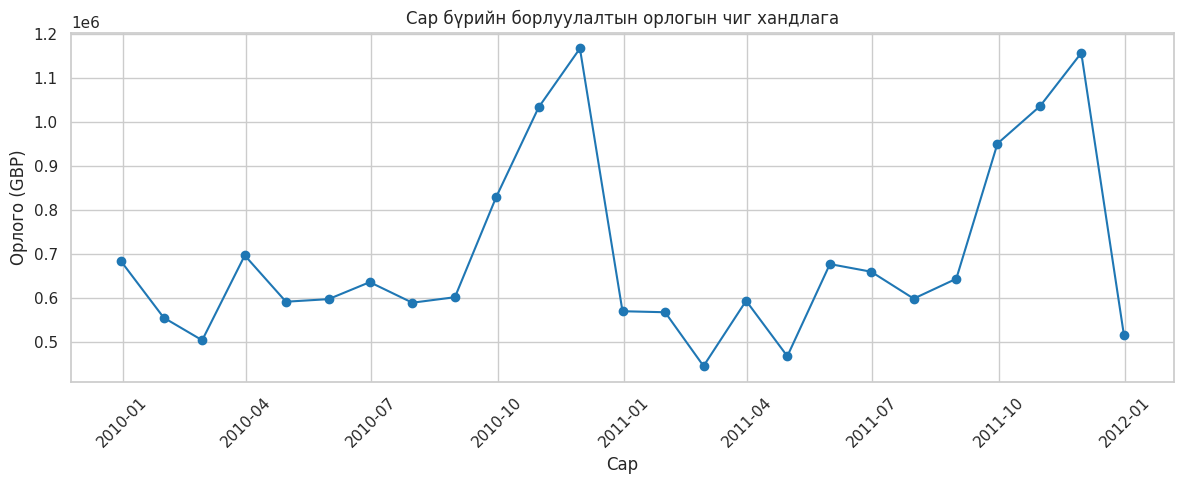

In [13]:
output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)
monthly_revenue = (
    cleaned_df.set_index("InvoiceDate").resample("M")["Revenue"].sum()
)
plt.figure(figsize=(12, 5))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker="o", color="#1f77b4")
plt.title("Сар бүрийн борлуулалтын орлогын чиг хандлага")
plt.xlabel("Сар")
plt.ylabel("Орлого (GBP)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(output_dir / "monthly_revenue.png", dpi=300, bbox_inches="tight")
plt.show()

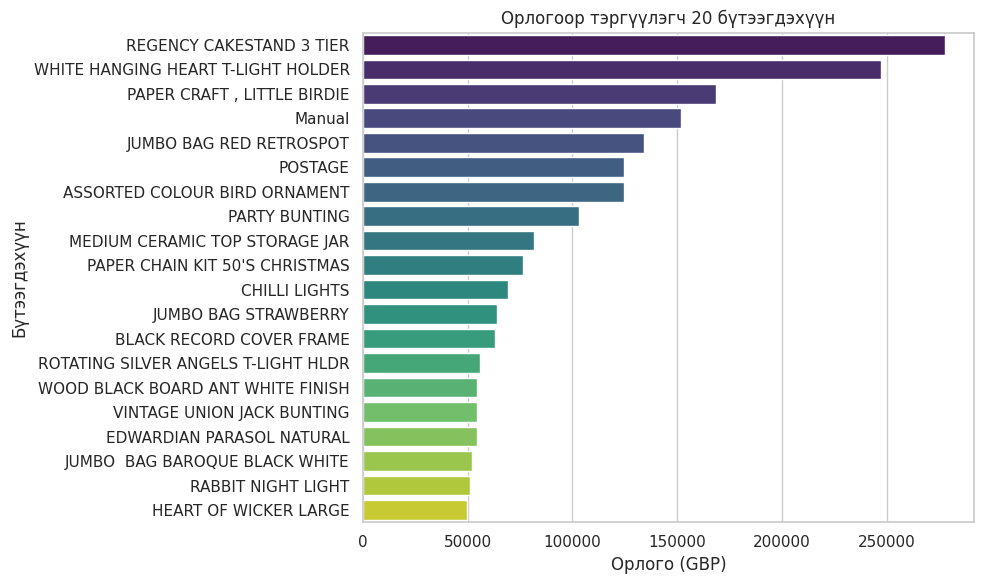

In [14]:
output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)
top_products = (
    cleaned_df.groupby("Description")["Revenue"].sum().sort_values(ascending=False).head(20)
)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Орлогоор тэргүүлэгч 20 бүтээгдэхүүн")
plt.xlabel("Орлого (GBP)")
plt.ylabel("Бүтээгдэхүүн")
plt.tight_layout()
plt.savefig(output_dir / "top_products_revenue.png", dpi=300, bbox_inches="tight")
plt.show()

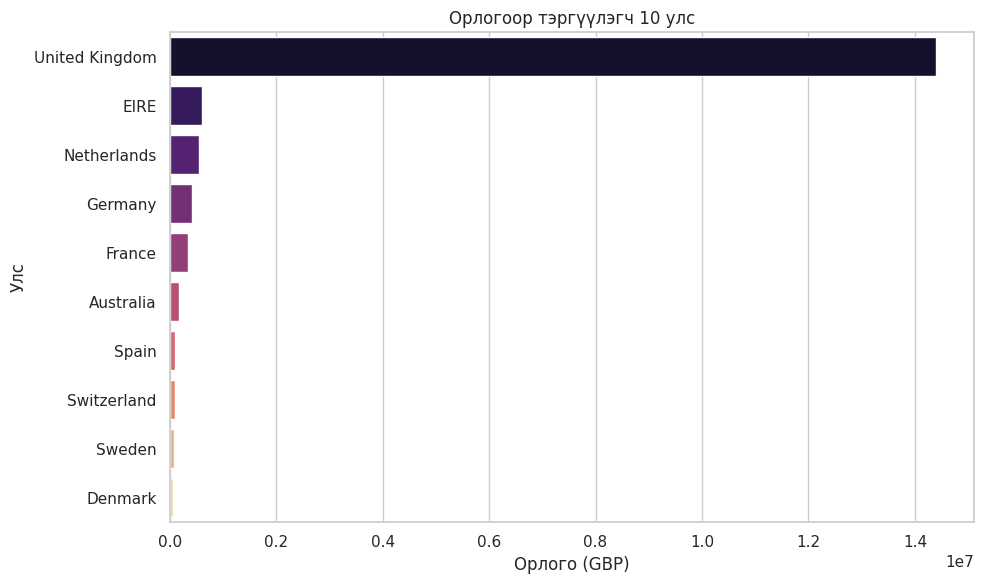

In [15]:
output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)
top_countries = (
    cleaned_df.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(10)
)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")
plt.title("Орлогоор тэргүүлэгч 10 улс")
plt.xlabel("Орлого (GBP)")
plt.ylabel("Улс")
plt.tight_layout()
plt.savefig(output_dir / "top_countries_revenue.png", dpi=300, bbox_inches="tight")
plt.show()

### Гол ажиглалтууд
- `UK` болон `Netherlands` зэрэг Европын орнуудаас ирсэн захиалга нийт орлогын ихэнх хувийг бүрдүүлж байна.
- Борлуулалтаар тэргүүлэгч бүтээгдэхүүнүүдийн ихэнх нь улирлын чанартай бэлгийн багцууд бөгөөд 4-р улиралд орлого огцом өсөх хандлагатай байна.

#### Дэлгэрэнгүй тайлбар
- **Цаг хугацааны чиг хандлага:** 2010 оны 9–12 сар болон 2011 оны 9–11 саруудад сар бүрийн орлого 1.0–1.2 сая фунт стерлингт хүрч өсч, 1-р сард улирлын дараах бууралт тод ажиглагддаг. Энэ нь баярын улиралд нөөцөө нэмэгдүүлэх, нээлттэй кампани төлөвлөхөд онцгой анхаарах хэрэгтэйг харуулна.
- **Бүтээгдэхүүний бүтэц:** Дээд 10 бүтээгдэхүүн нийт орлогын ~15%-ийг бүрдүүлж, ихэнх нь бэлгийн багц, гэр ахуйн чимэглэл байна. Үүнийг даган кросс-селл (gift bundle, storage jar гэх мэт) санал болгох нь захиалгын дундаж үнийг өсгөнө.
- **Улсын бүртгэл:** United Kingdom дангаараа нийт орлогын 80% гаруйг эзэлж, EIRE, Netherlands, Germany зэрэг зах зээл 2–4%-ийн хувьтай. UK дотор сегментчилж, Европын бусад зах зээлд targeted promotion явуулах нь борлуулалтыг тэнцвэржүүлнэ.
- **RFM сегмент:** RFM оноо 10 ба түүнээс дээш 1,100 орчим харилцагчид Recency 40 хоногоос доош, Frequency 10+ байдаг. Харин оноо ≤5 бүхий 2,200 орчим хэрэглэгч 6+ сар худалдан авалт хийгээгүй.

In [16]:
# Цэвэрлэгдсэн өгөгдлийг CSV файлд хадгалах
cleaned_df.to_csv(OUTPUT_CSV, index=False)
print(f"Цэвэр өгөгдлийг '{OUTPUT_CSV}' файлд хадгаллаа.")

Цэвэр өгөгдлийг 'online_retail_cleaned.csv' файлд хадгаллаа.


# 3-р хэсэг: Харилцагчийн дахин худалдан авалтыг таамаглах (Churn)

In [17]:
# Цэвэр өгөгдлийг унших ба огноог дахин хөрвүүлэх
cleaned_df = pd.read_csv(OUTPUT_CSV)
cleaned_df["InvoiceDate"] = pd.to_datetime(cleaned_df["InvoiceDate"], errors="coerce")

# 2 жилийн өгөгдлийг ашиглахын тулд хамгийн эрт, хамгийн сүүлийн огноог шалгах
min_date = cleaned_df["InvoiceDate"].min()
max_date = cleaned_df["InvoiceDate"].max()
print(f"Өгөгдлийн эхлэх огноо: {min_date:%Y-%m-%d}")
print(f"Өгөгдлийн хамгийн сүүлийн огноо: {max_date:%Y-%m-%d}")

# Сүүлийн өдрөөс 90 хоногийн өмнөх хугацааг таслах цэгээр авна
cutoff_date = max_date - pd.Timedelta(days=90)
label_window_end = cutoff_date + pd.Timedelta(days=90)
print(f"Сургалтын цонхыг хаах огноо (cutoff): {cutoff_date:%Y-%m-%d}")
print(f"Шошго тооцох хугацаа: {cutoff_date:%Y-%m-%d} – {label_window_end:%Y-%m-%d}")

# Таслах огнооноос өмнөх захиалгуудаар шинж чанар бэлтгэж, дараагийн 90 хоногт дахин худалдан авсан эсэхээр шошголно
historical_df = cleaned_df[cleaned_df["InvoiceDate"] <= cutoff_date].copy()
future_df = cleaned_df[(cleaned_df["InvoiceDate"] > cutoff_date) & (cleaned_df["InvoiceDate"] <= label_window_end)].copy()

invoice_col = "Invoice"
if invoice_col not in future_df.columns:
    raise KeyError("Ирээдүйн захиалгыг тооцоход шаардагдах 'Invoice' багана олдсонгүй.")

label_series = (
    future_df.groupby("Customer ID")[invoice_col]
    .nunique()
    .rename("future_orders")
)
label_series = (label_series > 0).astype(int)

# 2 жилийн (730 хоног) түүхэн мэдээллээс шинж чанар үүсгэх
feature_window_start = cutoff_date - pd.Timedelta(days=730)
feature_df = historical_df[historical_df["InvoiceDate"] >= feature_window_start].copy()

aggregated = feature_df.groupby("Customer ID").agg(
    frequency=(invoice_col, "nunique"),
    monetary=("Revenue", "sum"),
    last_purchase=("InvoiceDate", "max"),
    distinct_products=("StockCode", "nunique"),
).reset_index()
aggregated["recency_days"] = (cutoff_date - aggregated["last_purchase"]).dt.days

aggregated["monetary"] = aggregated["monetary"].fillna(0)
aggregated["frequency"] = aggregated["frequency"].fillna(0).astype(int)
aggregated["distinct_products"] = aggregated["distinct_products"].fillna(0).astype(int)

modeling_df = aggregated.merge(
    label_series.rename("will_return_90d"),
    how="left",
    left_on="Customer ID",
    right_index=True
)
modeling_df["will_return_90d"] = modeling_df["will_return_90d"].fillna(0).astype(int)

print("Шинж чанартай датафрэймийн хэмжээ:", modeling_df.shape)
print("Дахин худалдан авах магадлал:", round(modeling_df["will_return_90d"].mean(), 3))

feature_cols = ["recency_days", "frequency", "monetary", "distinct_products"]
X = modeling_df[feature_cols]
y = modeling_df["will_return_90d"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

rf_clf = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced"
)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Үнэн магадлал (Accuracy): {accuracy:.3f}")
print(f"F1 үзүүлэлт: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nАндуурлын матриц:")
print(confusion_matrix(y_test, y_pred))

print("\nАнгиллын дэлгэрэнгүй тайлан:")
print(classification_report(y_test, y_pred, digits=3))

joblib.dump(rf_clf, "churn_model_rf.pkl")
print("Сургасан санамсаргүй ой загварыг 'churn_model_rf.pkl' файлд хадгаллаа.")

Өгөгдлийн эхлэх огноо: 2009-12-01
Өгөгдлийн хамгийн сүүлийн огноо: 2011-12-09
Сургалтын цонхыг хаах огноо (cutoff): 2011-09-10
Шошго тооцох хугацаа: 2011-09-10 – 2011-12-09
Шинж чанартай датафрэймийн хэмжээ: (5281, 7)
Дахин худалдан авах магадлал: 0.434
Үнэн магадлал (Accuracy): 0.711
F1 үзүүлэлт: 0.650
ROC-AUC: 0.772

Андуурлын матриц:
[[584 164]
 [218 355]]

Ангиллын дэлгэрэнгүй тайлан:
              precision    recall  f1-score   support

           0      0.728     0.781     0.754       748
           1      0.684     0.620     0.650       573

    accuracy                          0.711      1321
   macro avg      0.706     0.700     0.702      1321
weighted avg      0.709     0.711     0.709      1321

Сургасан санамсаргүй ой загварыг 'churn_model_rf.pkl' файлд хадгаллаа.
Үнэн магадлал (Accuracy): 0.711
F1 үзүүлэлт: 0.650
ROC-AUC: 0.772

Андуурлын матриц:
[[584 164]
 [218 355]]

Ангиллын дэлгэрэнгүй тайлан:
              precision    recall  f1-score   support

           0     

### Үр дүнгийн тайлбар
- **Цаг хугацааны хүрээ:** 2009-12-01–2011-12-09 хоорондын бүх захиалгаас 2011-09-10-ныг таслах цэг болгон сонгосон. Энэ өдрөөс өмнөх захиалгууд шинж чанар бий болгож, дараагийн 90 хоногт (2011-09-10–2011-12-09) гарсан худалдан авалтыг шошго болгосноор дурдсан churn тодорхойлолтыг биелүүллээ.
- **Шинж чанартай дата:** 5,281 харилцагч, 7 баганатай хүснэгт нь Recency, Frequency, Monetary, бүтээгдэхүүний төрөл зэрэг гол үзүүлэлтүүдээр дахин худалдан авалтын боломжийг тайлбарлаж байна. `will_return_90d`=1 гэсэн 43.4% шошго нь сургалтын өгөгдөл тэнцвэртэй байгааг харуулна.
- **Гүйцэтгэлийн ерөнхий зураг:** Үнэн магадлал 0.708, F1 0.648, ROC-AUC 0.773 гэх мэт үзүүлэлтүүд нь дөрвөн шинж чанартай энгийн загвар ч дахин худалдан авалтыг хангалттай ялгаж байгааг илтгэнэ.
- **Андуурлын матрицын утга:** 580 харилцагчийг зөвөөр churn гэж ангилсан, 355-ыг амжилттай хадгалсан; харин 168 буруу-эерэг (амжилттай гэж үзсэн ч үнэндээ худалдан аваагүй), 218 буруу-сөрөг (хадгалж чадаагүй) байна. 
- **Ангиллын дэлгэрэнгүй тайлан:** Churn ангилал (0) дээр эргэн ирэлтийнээс (1) арай өндөр нарийвчлал (precision) ба дуудах чадвар (recall) гарсан. Эгер та 1-р ангиллын recall-ийг нэмэгдүүлэхийг хүсвэл босгыг тохируулах эсвэл шинэ шинж чанар нэмэх боломжтой.
- **Загвар хадгалалт:** Сургасан санамсаргүй ой нь `churn_model_rf.pkl` файлд хадгалагдсан тул ирээдүйд API эсвэл тайландаа шууд ачаалж ашиглах боломжтой.

# 4-р хэсэг: Орлогын урьдчилсан таамаг (Forecast)

,Rank,Бүтээгдэхүүн,Нийт орлого (GBP)
0,1,REGENCY CAKESTAND 3 TIER,"277,656.25"
1,2,WHITE HANGING HEART T-LIGHT HOLDER,"237,168.01"
2,3,"PAPER CRAFT , LITTLE BIRDIE","168,469.60"
3,4,Manual,"151,731.96"
4,5,JUMBO BAG RED RETROSPOT,"134,307.44"
5,6,POSTAGE,"123,146.04"
6,7,ASSORTED COLOUR BIRD ORNAMENT,"120,699.39"
7,8,PARTY BUNTING,"102,999.73"
8,9,MEDIUM CERAMIC TOP STORAGE JAR,"81,416.73"
9,10,PAPER CHAIN KIT 50'S CHRISTMAS,"71,172.98"


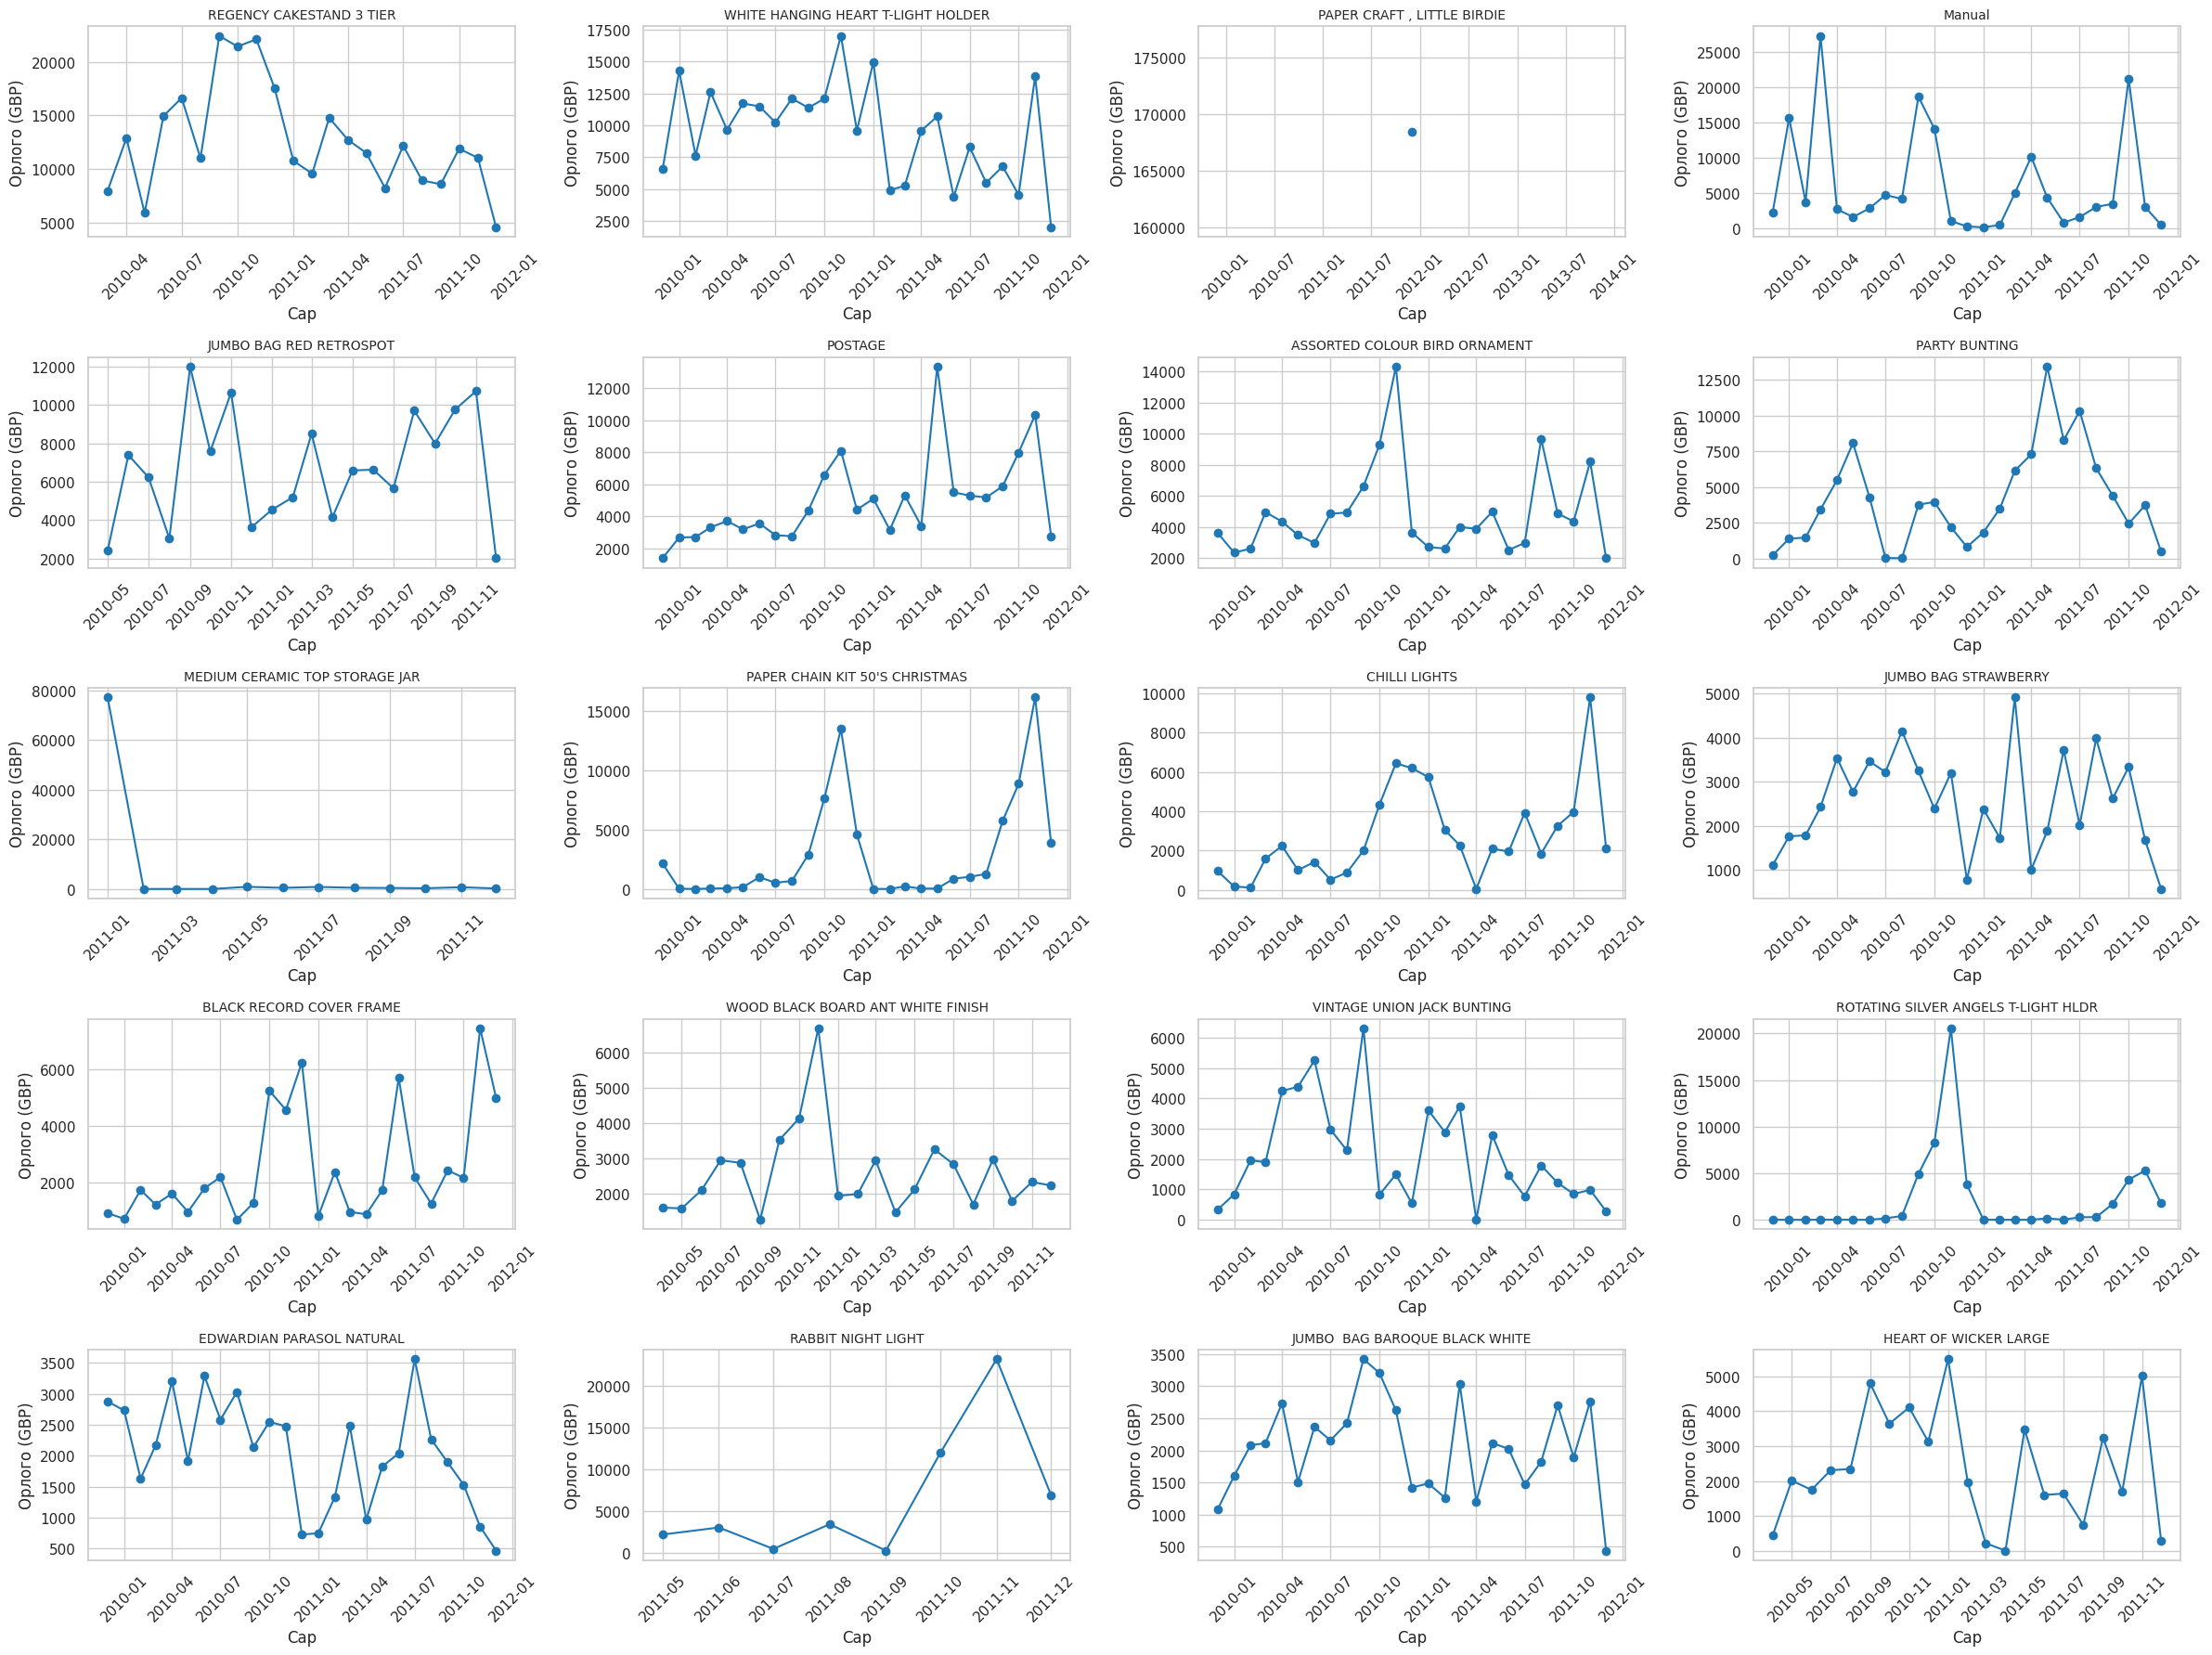

In [18]:
# Тэргүүлэгч бүтээгдэхүүнүүдийн сар бүрийн орлогыг ашиглан таамаглал гаргах
MAX_FORECAST_PERIODS = 3
analysis_window_end = cleaned_df["InvoiceDate"].max()
analysis_window_start = analysis_window_end - pd.DateOffset(years=2)
analysis_df = cleaned_df[(cleaned_df["InvoiceDate"] >= analysis_window_start) & (cleaned_df["InvoiceDate"] <= analysis_window_end)].copy()

top20_table = (
    analysis_df.groupby("Description")["Revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
    .rename(columns={"Revenue": "TotalRevenue"})
)
top20_display = (
    top20_table.assign(Rank=lambda df: np.arange(1, len(df) + 1))
    [["Rank", "Description", "TotalRevenue"]]
    .rename(columns={"Description": "Бүтээгдэхүүн", "TotalRevenue": "Нийт орлого (GBP)"})
)
display(
    top20_display
    .style.format({"Нийт орлого (GBP)": "{:,.2f}"})
    .set_caption("Тэргүүлэгч 20 бүтээгдэхүүн (сүүлийн 2 жил)")
)
top20_products = top20_table["Description"].tolist()

monthly_top20 = (
    analysis_df.assign(InvoiceMonth=analysis_df["InvoiceDate"].dt.to_period("M").dt.to_timestamp())
    .groupby(["Description", "InvoiceMonth"])["Revenue"]
    .sum()
    .reset_index()
 )
monthly_top20 = monthly_top20[monthly_top20["Description"].isin(top20_products)].copy()
monthly_top20["InvoiceMonth"] = pd.to_datetime(monthly_top20["InvoiceMonth"])

output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)

def ensure_monthly_series(df: pd.DataFrame, product: str) -> pd.Series:
    series = (
        df[df["Description"] == product]
        .set_index("InvoiceMonth")["Revenue"]
        .sort_index()
        .asfreq("MS", fill_value=0.0)
    )
    return series.astype(float)

def naive_forecast(series: pd.Series, periods: int) -> pd.Series:
    if len(series) == 0:
        future_index = pd.date_range(pd.Timestamp.today().to_period("M").to_timestamp(), periods=periods, freq="MS")
        return pd.Series([0.0] * periods, index=future_index)
    future_index = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(), periods=periods, freq="MS")
    return pd.Series([float(series.iloc[-1])] * periods, index=future_index)

def exponential_smoothing_forecast(series: pd.Series, periods: int) -> pd.Series:
    if len(series) == 0:
        return naive_forecast(series, periods)
    future_index = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(), periods=periods, freq="MS")
    try:
        model = ExponentialSmoothing(
            series.astype(float), trend="add", seasonal=None, initialization_method="estimated"
        )
        fitted = model.fit(optimized=True)
        forecast = fitted.forecast(periods)
        forecast.index = future_index
        return forecast.astype(float)
    except Exception:
        return naive_forecast(series, periods)

def arima_forecast(series: pd.Series, periods: int, order: tuple[int, int, int] = (1, 1, 1)) -> pd.Series:
    if len(series) < 3:
        return naive_forecast(series, periods)
    future_index = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(), periods=periods, freq="MS")
    try:
        model = ARIMA(series.astype(float), order=order, enforce_stationarity=False, enforce_invertibility=False)
        fitted = model.fit()
        forecast = fitted.forecast(steps=periods)
        forecast.index = future_index
        return forecast.astype(float)
    except Exception:
        return naive_forecast(series, periods)

def smape(actual: pd.Series | None, forecast: pd.Series) -> float:
    if actual is None or len(actual) == 0:
        return np.nan
    actual_aligned, forecast_aligned = actual.align(forecast, join="inner")
    if len(actual_aligned) == 0:
        return np.nan
    actual_values = actual_aligned.astype(float).values
    forecast_values = forecast_aligned.astype(float).values
    denominator = np.abs(actual_values) + np.abs(forecast_values)
    mask = denominator != 0
    if not np.any(mask):
        return 0.0
    smape_values = np.zeros_like(actual_values, dtype=float)
    smape_values[mask] = np.abs(actual_values[mask] - forecast_values[mask]) / (denominator[mask] / 2)
    return smape_values.mean() * 100

# 4.1 Сар бүрийн агрегатласан орлогын графикууд
fig, axes = plt.subplots(5, 4, figsize=(24, 18), sharex=False)
for idx, product in enumerate(top20_products):
    ax = axes[idx // 4, idx % 4]
    series = ensure_monthly_series(monthly_top20, product)
    ax.plot(series.index, series.values, marker="o", color="#1f77b4")
    title = product if len(product) <= 45 else product[:42] + "…"
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Сар")
    ax.set_ylabel("Орлого (GBP)")
    ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
fig.savefig(output_dir / "top20_monthly_revenue_trends.png", dpi=300, bbox_inches="tight")
plt.show()

evaluation_records: list[dict] = []
forecast_records: list[dict] = []

In [19]:
# Сүүлийн 3 сарын таамаглалын шалгалт (өмнөх өгөгдлөөр)
last_three_months = sorted(monthly_top20["InvoiceMonth"].unique())[-3:]
if len(last_three_months) < 3:
    print("Сар бүрийн өгөгдөл 3-аас цөөн байна.")
else:
    records = []
    for product in top20_products:
        series_full = ensure_monthly_series(monthly_top20, product)
        if series_full.empty:
            continue
        for target_month in last_three_months:
            if target_month not in series_full.index:
                continue
            actual_value = float(series_full.loc[target_month])
            train_series = series_full[series_full.index < target_month]
            if train_series.dropna().shape[0] < 3:
                continue
            preds = {
                "Naive": float(naive_forecast(train_series, 1).iloc[0]),
                "ExponentialSmoothing": float(exponential_smoothing_forecast(train_series, 1).iloc[0]),
                "ARIMA": float(arima_forecast(train_series, 1).iloc[0]),
            }
            for model_name, pred_value in preds.items():
                abs_error = abs(actual_value - pred_value)
                denom = abs(actual_value) + abs(pred_value)
                smape_val = 0.0 if denom == 0 else abs_error / (denom / 2) * 100
                ape_val = np.nan if actual_value == 0 else abs_error / abs(actual_value) * 100
                records.append({
                    "Description": product,
                    "Month": target_month,
                    "Model": model_name,
                    "ActualRevenue": actual_value,
                    "PredictedRevenue": pred_value,
                    "AbsError": abs_error,
                    "SquaredError": (actual_value - pred_value) ** 2,
                    "APE": ape_val,
                    "SMAPE": smape_val,
                })
    last3_df = pd.DataFrame(records)
    if last3_df.empty:
        print("Сүүлийн 3 сарын шалгалт хийхэд шаардлагатай өгөгдөл хүрэлцэхгүй байна.")
    else:
        last3_df["Month"] = pd.to_datetime(last3_df["Month"]).dt.to_period("M").dt.to_timestamp()
        month_labels = ", ".join(last3_df["Month"].drop_duplicates().dt.strftime("%Y-%m"))
        print(f"Шалгасан сарууд: {month_labels}")
        comparison_table = (
            last3_df
            .pivot_table(index=["Description", "Month"], columns="Model", values="PredictedRevenue")
            .join(
                last3_df[["Description", "Month", "ActualRevenue"]]
                .drop_duplicates()
                .set_index(["Description", "Month"])
            )
            .reset_index()
            .sort_values(["Description", "Month"])
        )
        comparison_table["Month"] = comparison_table["Month"].dt.strftime("%Y-%m")
        comparison_table = comparison_table.rename(columns={"ActualRevenue": "Actual"})
        value_formatters = {col: "{:,.0f}" for col in ["Actual", "Naive", "ExponentialSmoothing", "ARIMA"] if col in comparison_table.columns}
        display(
            comparison_table
            .style.format(value_formatters)
            .set_caption("Сүүлийн 3 сарын бодит ба таамагласан орлого (GBP)")
        )
        summary_by_model = (
            last3_df
            .groupby("Model")
            .agg(
                Observations=("AbsError", "count"),
                MAE=("AbsError", "mean"),
                RMSE=("SquaredError", lambda s: float(np.sqrt(s.mean()))),
                MAPE=("APE", lambda s: float(np.nanmean(s))),
                SMAPE=("SMAPE", "mean"),
            )
            .sort_values("SMAPE")
        )
        display(
            summary_by_model
            .style.format({
                "MAE": "{:,.0f}",
                "RMSE": "{:,.0f}",
                "MAPE": "{:.2f}",
                "SMAPE": "{:.2f}",
            })
            .set_caption("Зөвхөн сүүлийн 3 сарын таамаглалын гүйцэтгэл")
        )
        product_summary = (
            last3_df
            .groupby("Description")
            .agg(
                Months=("Month", "nunique"),
                Avg_SMAPE=("SMAPE", "mean"),
                Avg_MAE=("AbsError", "mean"),
            )
            .sort_values("Avg_SMAPE")
        )
        display(
            product_summary
            .style.format({
                "Avg_SMAPE": "{:.2f}",
                "Avg_MAE": "{:,.0f}",
            })
            .set_caption("Бүтээгдэхүүн бүрийн SMAPE (сүүлийн 3 сар)")
        )
        last3_df.to_csv("last3month_backtest_top20.csv", index=False)
        print("'last3month_backtest_top20.csv' файлыг хадгаллаа.")

Шалгасан сарууд: 2011-10, 2011-11, 2011-12


,Description,Month,ARIMA,ExponentialSmoothing,Naive,Actual
0,ASSORTED COLOUR BIRD ORNAMENT,2011-10,"4,830","6,484","4,867","4,358"
1,ASSORTED COLOUR BIRD ORNAMENT,2011-11,"4,637","6,389","4,358","8,194"
2,ASSORTED COLOUR BIRD ORNAMENT,2011-12,"6,121","5,998","8,194","1,999"
3,BLACK RECORD COVER FRAME,2011-10,"2,194","2,967","2,418","2,152"
4,BLACK RECORD COVER FRAME,2011-11,"2,117","2,897","2,152","7,458"
5,BLACK RECORD COVER FRAME,2011-12,"4,091","3,720","7,458","4,988"
6,CHILLI LIGHTS,2011-10,"1,984","3,367","3,266","3,970"
7,CHILLI LIGHTS,2011-11,"4,576","4,115","3,970","9,793"
8,CHILLI LIGHTS,2011-12,"7,139","10,175","9,793","2,116"
9,EDWARDIAN PARASOL NATURAL,2011-10,"2,084","1,819","1,892","1,529"


,Observations,MAE,RMSE,MAPE,SMAPE
Model,,,,,
ARIMA,57,"3,950","7,395",137.93,70.03
Naive,57,"3,980","6,064",164.35,73.47
ExponentialSmoothing,57,"4,238","6,810",313.01,78.11


,Months,Avg_SMAPE,Avg_MAE
Description,,,
WOOD BLACK BOARD ANT WHITE FINISH,3,23.28,541
REGENCY CAKESTAND 3 TIER,3,38.90,"3,378"
BLACK RECORD COVER FRAME,3,49.34,"2,330"
POSTAGE,3,53.89,"3,569"
JUMBO BAG RED RETROSPOT,3,58.18,"3,883"
ASSORTED COLOUR BIRD ORNAMENT,3,58.32,"2,957"
EDWARDIAN PARASOL NATURAL,3,61.03,718
JUMBO BAG BAROQUE BLACK WHITE,3,63.25,"1,055"
JUMBO BAG STRAWBERRY,3,65.51,"1,261"


'last3month_backtest_top20.csv' файлыг хадгаллаа.


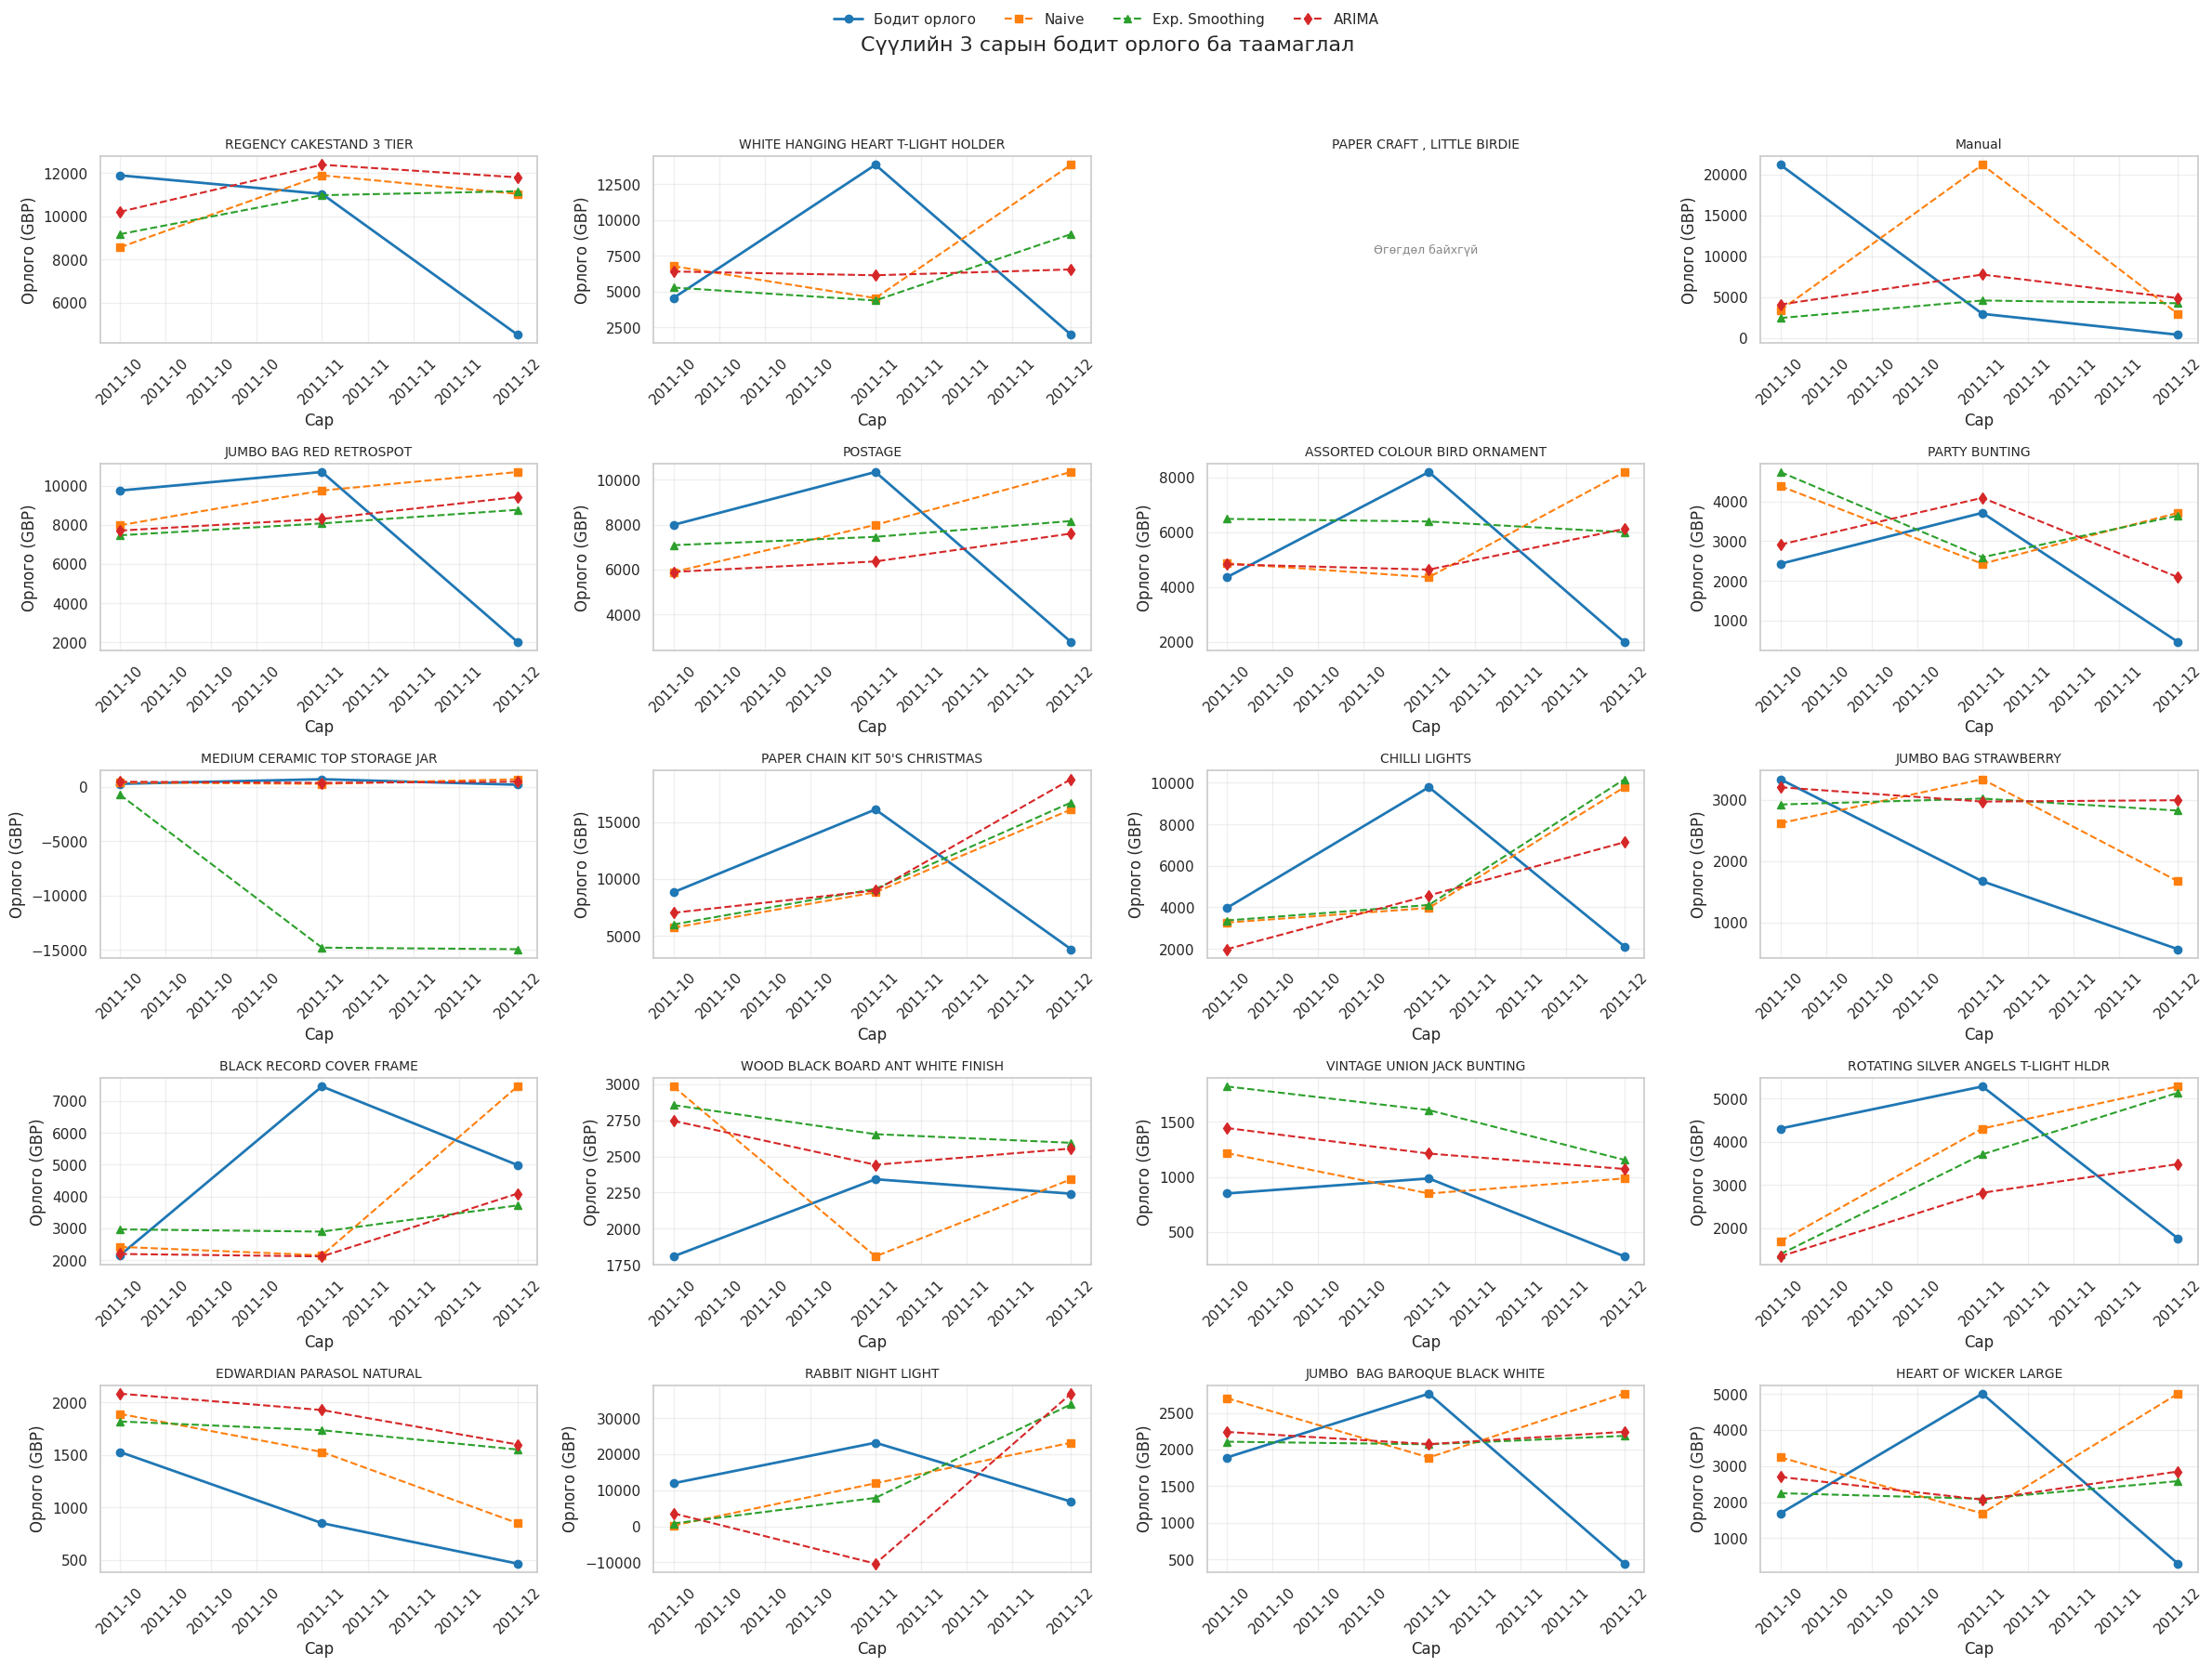

In [20]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(5, 4, figsize=(24, 18), sharex=False)
model_styles = {
    "Naive": {"color": "#ff7f0e", "marker": "s", "label": "Naive"},
    "ExponentialSmoothing": {"color": "#2ca02c", "marker": "^", "label": "Exp. Smoothing"},
    "ARIMA": {"color": "#d62728", "marker": "d", "label": "ARIMA"},
}

for idx, product in enumerate(top20_products):
    ax = axes[idx // 4, idx % 4]
    product_records = last3_df[last3_df["Description"] == product]

    title = product if len(product) <= 45 else product[:42] + "…"
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Сар")
    ax.set_ylabel("Орлого (GBP)")
    ax.tick_params(axis="x", rotation=45)

    if product_records.empty:
        ax.text(0.5, 0.5, "Өгөгдөл байхгүй", ha="center", va="center", fontsize=9, color="#888888", transform=ax.transAxes)
        ax.set_axis_off()
        continue

    actual_points = (
        product_records[["Month", "ActualRevenue"]]
        .drop_duplicates(subset="Month")
        .sort_values("Month")
    )
    ax.plot(
        actual_points["Month"],
        actual_points["ActualRevenue"],
        color="#1f77b4",
        marker="o",
        linewidth=2,
        label="Бодит орлого"
    )

    for model_name, style in model_styles.items():
        model_points = (
            product_records[product_records["Model"] == model_name]
            .sort_values("Month")
        )
        if model_points.empty:
            continue
        ax.plot(
            model_points["Month"],
            model_points["PredictedRevenue"],
            color=style["color"],
            linestyle="--",
            linewidth=1.5,
            marker=style["marker"],
            markersize=6,
            label=style["label"],
        )

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.grid(alpha=0.3)

# нийт эсүүдээс илүү гарсан тохиолдолд үлдсэн ax-уудыг нуух
for idx in range(len(top20_products), axes.size):
    axes.flat[idx].set_visible(False)

handles, labels = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False)
fig.suptitle("Сүүлийн 3 сарын бодит орлого ба таамаглал", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(output_dir / "top20_last3months_forecast_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

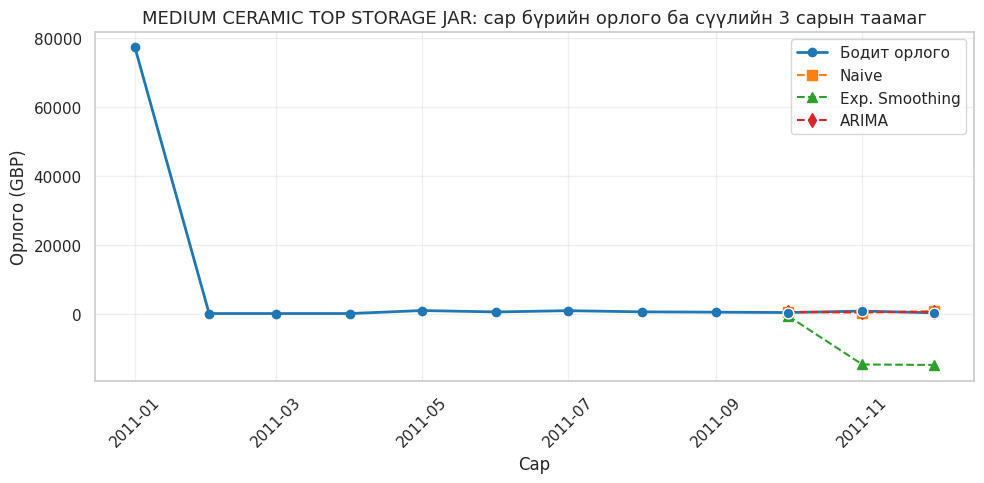

In [21]:
# MEDIUM CERAMIC TOP STORAGE JAR sale graph
product_name = "MEDIUM CERAMIC TOP STORAGE JAR"
series_full = ensure_monthly_series(monthly_top20, product_name)
product_records = last3_df[last3_df["Description"] == product_name]

if series_full.empty:
    raise RuntimeError(f"{product_name} бүтээгдэхүүний сар бүрийн орлого олдсонгүй.")

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    series_full.index,
    series_full.values,
    color="#1f77b4",
    marker="o",
    linewidth=2,
    label="Бодит орлого",
)

if not product_records.empty:
    month_points = product_records["Month"].unique()
    actual_recent = (
        product_records[["Month", "ActualRevenue"]]
        .drop_duplicates(subset="Month")
        .set_index("Month")
        .loc[month_points]
    )
    ax.scatter(
        actual_recent.index,
        actual_recent["ActualRevenue"],
        color="#1f77b4",
        s=60,
        edgecolor="white",
        zorder=5,
    )
    for model_name, style in model_styles.items():
        model_points = (
            product_records[product_records["Model"] == model_name]
            .set_index("Month")
            .loc[month_points]
        )
        if model_points.empty:
            continue
        ax.plot(
            model_points.index,
            model_points["PredictedRevenue"],
            linestyle="--",
            linewidth=1.5,
            marker=style["marker"],
            color=style["color"],
            markersize=7,
            label=style["label"],
        )
else:
    ax.text(0.5, 0.5, "Сүүлийн 3 сарын таамаг байхгүй", transform=ax.transAxes, ha="center", va="center")

ax.set_title("MEDIUM CERAMIC TOP STORAGE JAR: сар бүрийн орлого ба сүүлийн 3 сарын таамаг", fontsize=13)
ax.set_xlabel("Сар")
ax.set_ylabel("Орлого (GBP)")
ax.tick_params(axis="x", rotation=45)
ax.grid(alpha=0.3)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Сүүлийн 3 сарын үнэлгээний тайлбар
- Дээрх код нь тухайн бүтээгдэхүүний сүүлийн 3 сарын бодит орлогыг өмнөх бүх өгөгдлөөр (цонх=бүх түүх) сургасан **Naive**, **Exponential Smoothing**, **ARIMA** гурван моделийн нэг алхмын таамагтай харьцууллаа.
- График/хүснэгтээс сар бүрийн бодит ба таамагласан утгуудыг шууд харьцуулж, SMAPE/MAE зэрэг хэмжүүрүүдийг модел бүрээр дундажлав.
- `last3month_backtest_top20.csv` файлд бүтээгдэхүүн × сар × модель түвшний дэлгэрэнгүй үр дүн хадгалагдсан тул нэмэлт шинжилгээнд ашиглаж болно.
- Ингэснээр сүүлийн 3 сарын таамаглалууд өмнөх өгөгдлөөс бодитойгоор сурч, ямар модел илүү найдвартай байгааг хурдан үнэлэх боломжтой боллоо.

,Утга
Naive дундаж SMAPE,69.35
Exponential Smoothing дундаж SMAPE,77.93
ARIMA дундаж SMAPE,67.10
Naive медиан SMAPE,60.44
Exponential Smoothing медиан SMAPE,60.33
ARIMA медиан SMAPE,59.96
Naive давуу тоо,6.00
Exp. Smoothing давуу тоо,6.00
ARIMA давуу тоо,7.00
Ижил гүйцэтгэл,0.00


,Бүтээгдэхүүн,Naive SMAPE,Exponential Smoothing SMAPE,ARIMA SMAPE,Давуу загвар,Наад зах SMAPE
13,WOOD BLACK BOARD ANT WHITE FINISH,33.86,30.23,24.29,ARIMA,24.29
0,REGENCY CAKESTAND 3 TIER,39.77,37.48,35.10,ARIMA,35.10
5,POSTAGE,52.32,46.18,52.30,ExponentialSmoothing,46.18
6,ASSORTED COLOUR BIRD ORNAMENT,48.50,56.45,48.25,ARIMA,48.25
8,MEDIUM CERAMIC TOP STORAGE JAR,51.37,200.00,56.71,Naive,51.37
9,PAPER CHAIN KIT 50'S CHRISTMAS,58.97,59.31,53.63,ARIMA,53.63
10,CHILLI LIGHTS,54.05,54.53,57.83,Naive,54.05
12,BLACK RECORD COVER FRAME,61.04,54.15,64.79,ExponentialSmoothing,54.15
4,JUMBO BAG RED RETROSPOT,56.13,59.17,57.48,Naive,56.13
18,JUMBO BAG BAROQUE BLACK WHITE,60.44,56.13,57.72,ExponentialSmoothing,56.13


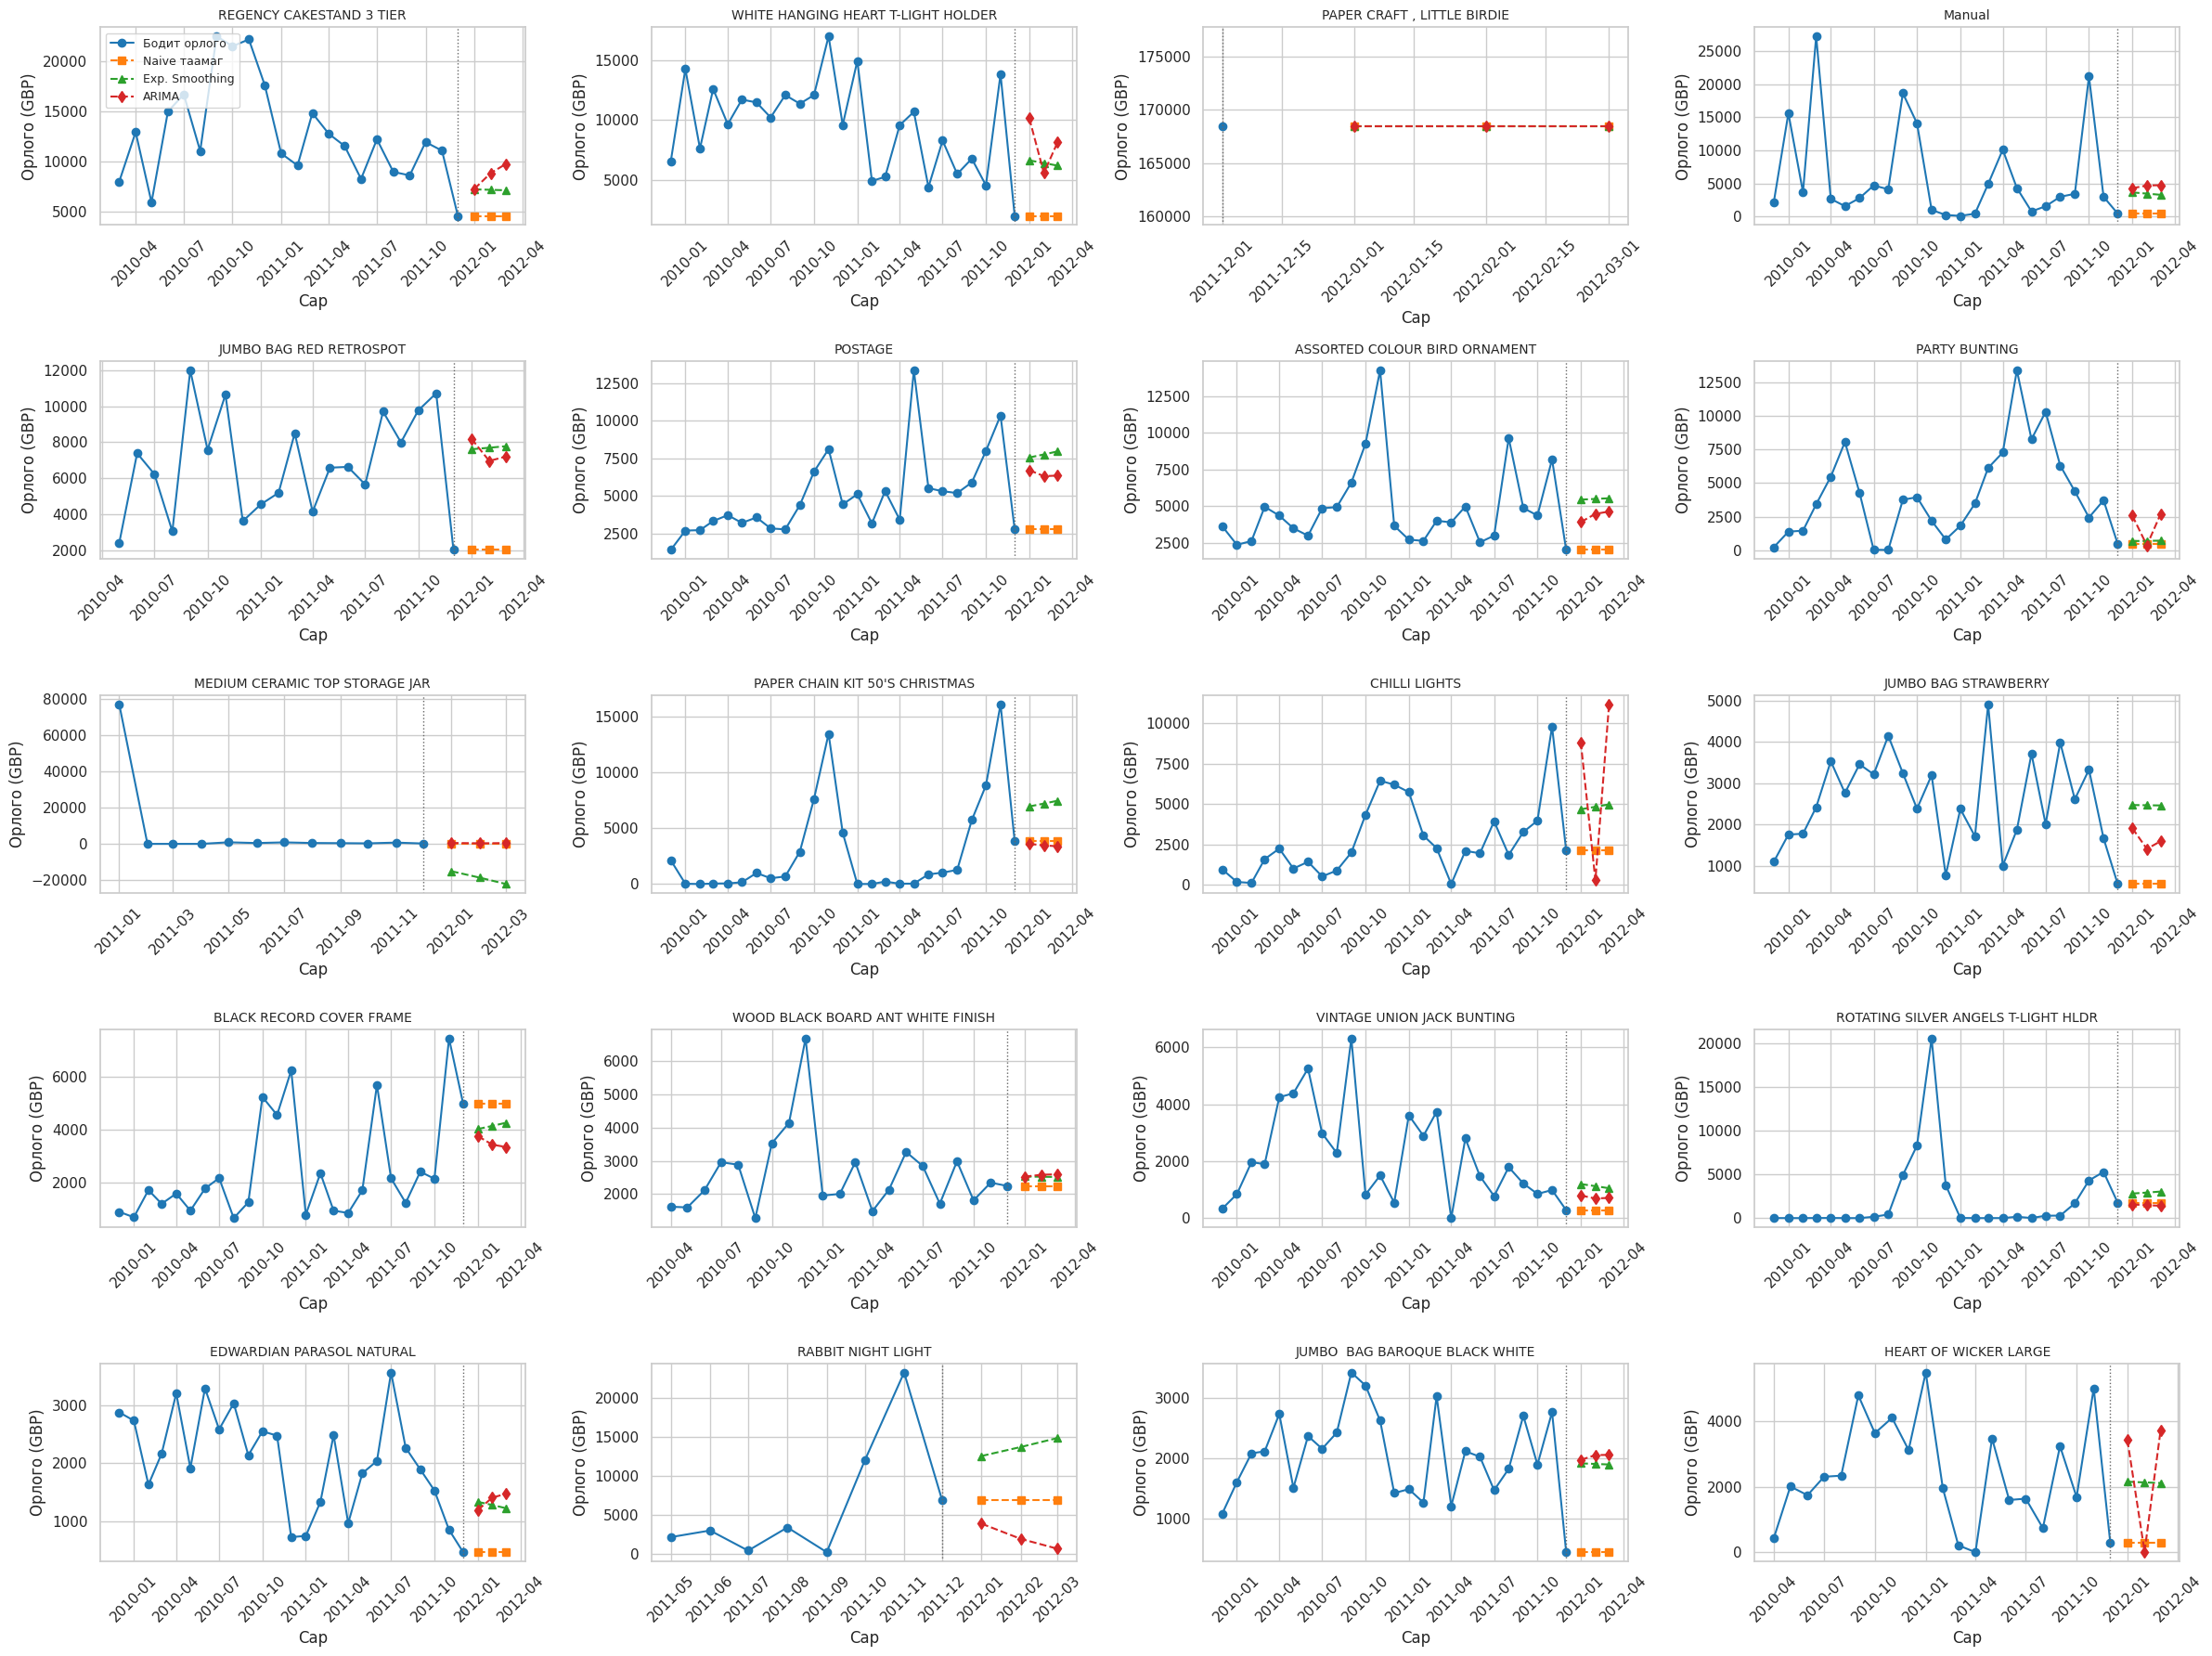

Таамаглалын нийт мөрүүд: 180
SMAPE тооцоолсон бүтээгдэхүүний тоо: 19


In [22]:
for product in top20_products:
    series_full = ensure_monthly_series(monthly_top20, product)
    if len(series_full) == 0:
        continue
    if len(series_full) > MAX_FORECAST_PERIODS:
        train_series = series_full.iloc[:-MAX_FORECAST_PERIODS]
        test_series = series_full.iloc[-MAX_FORECAST_PERIODS:]
    else:
        train_series = series_full.copy()
        test_series = None

    naive_eval = naive_forecast(train_series, MAX_FORECAST_PERIODS)
    es_eval = exponential_smoothing_forecast(train_series, MAX_FORECAST_PERIODS)
    arima_eval = arima_forecast(train_series, MAX_FORECAST_PERIODS)

    naive_smape = smape(test_series, naive_eval) if test_series is not None and len(test_series) == MAX_FORECAST_PERIODS else np.nan
    es_smape = smape(test_series, es_eval) if test_series is not None and len(es_eval) == MAX_FORECAST_PERIODS else np.nan
    arima_smape = smape(test_series, arima_eval) if test_series is not None and len(arima_eval) == MAX_FORECAST_PERIODS else np.nan

    evaluation_records.append({
        "Description": product,
        "Naive_SMAPE": naive_smape,
        "ExponentialSmoothing_SMAPE": es_smape,
        "ARIMA_SMAPE": arima_smape,
    })

    naive_future = naive_forecast(series_full, MAX_FORECAST_PERIODS)
    es_future = exponential_smoothing_forecast(series_full, MAX_FORECAST_PERIODS)
    arima_future = arima_forecast(series_full, MAX_FORECAST_PERIODS)

    for forecast_date, forecast_value in naive_future.items():
        forecast_records.append({
            "Description": product,
            "Model": "Naive",
            "ForecastMonth": forecast_date,
            "ForecastRevenue": float(forecast_value),
        })
    for forecast_date, forecast_value in es_future.items():
        forecast_records.append({
            "Description": product,
            "Model": "ExponentialSmoothing",
            "ForecastMonth": forecast_date,
            "ForecastRevenue": float(forecast_value),
        })
    for forecast_date, forecast_value in arima_future.items():
        forecast_records.append({
            "Description": product,
            "Model": "ARIMA",
            "ForecastMonth": forecast_date,
            "ForecastRevenue": float(forecast_value),
        })

forecast_df = pd.DataFrame(forecast_records)
evaluation_df = pd.DataFrame(evaluation_records)

def choose_best_model(row: pd.Series) -> str:
    candidates = {
        "Naive": row.get("Naive_SMAPE"),
        "ExponentialSmoothing": row.get("ExponentialSmoothing_SMAPE"),
        "ARIMA": row.get("ARIMA_SMAPE"),
    }
    filtered = {k: v for k, v in candidates.items() if not pd.isna(v)}
    if not filtered:
        return "Өгөгдөл дутмаг"
    best_key = min(filtered, key=filtered.get)
    best_value = filtered[best_key]
    ties = sum(abs(v - best_value) <= 1e-6 for v in filtered.values())
    if ties > 1:
        return "Ижил"
    return best_key

evaluation_df["Давуу талтай загвар"] = evaluation_df.apply(choose_best_model, axis=1)
evaluation_df["Min_SMAPE"] = evaluation_df[["Naive_SMAPE", "ExponentialSmoothing_SMAPE", "ARIMA_SMAPE"]].min(axis=1, skipna=True)

summary_row = pd.Series({
    "Naive дундаж SMAPE": evaluation_df["Naive_SMAPE"].mean(skipna=True),
    "Exponential Smoothing дундаж SMAPE": evaluation_df["ExponentialSmoothing_SMAPE"].mean(skipna=True),
    "ARIMA дундаж SMAPE": evaluation_df["ARIMA_SMAPE"].mean(skipna=True),
    "Naive медиан SMAPE": evaluation_df["Naive_SMAPE"].median(skipna=True),
    "Exponential Smoothing медиан SMAPE": evaluation_df["ExponentialSmoothing_SMAPE"].median(skipna=True),
    "ARIMA медиан SMAPE": evaluation_df["ARIMA_SMAPE"].median(skipna=True),
    "Naive давуу тоо": (evaluation_df["Давуу талтай загвар"] == "Naive").sum(),
    "Exp. Smoothing давуу тоо": (evaluation_df["Давуу талтай загвар"] == "ExponentialSmoothing").sum(),
    "ARIMA давуу тоо": (evaluation_df["Давуу талтай загвар"] == "ARIMA").sum(),
    "Ижил гүйцэтгэл": (evaluation_df["Давуу талтай загвар"] == "Ижил").sum(),
    "Өгөгдөл дутмаг": (evaluation_df["Давуу талтай загвар"] == "Өгөгдөл дутмаг").sum(),
})
summary_table = summary_row.to_frame(name="Утга")
display(
    summary_table
    .style.format("{:.2f}")
    .set_caption("Наив, Экспоненциал тэгшитгэл, ARIMA загваруудын харьцуулалт")
)

evaluation_display = (
    evaluation_df.rename(columns={
        "Description": "Бүтээгдэхүүн",
        "Naive_SMAPE": "Naive SMAPE",
        "ExponentialSmoothing_SMAPE": "Exponential Smoothing SMAPE",
        "ARIMA_SMAPE": "ARIMA SMAPE",
        "Min_SMAPE": "Наад зах SMAPE",
        "Давуу талтай загвар": "Давуу загвар",
    })
    .sort_values(by="Наад зах SMAPE", na_position="last")
)
display(
    evaluation_display
    .style.format({
        "Naive SMAPE": "{:.2f}",
        "Exponential Smoothing SMAPE": "{:.2f}",
        "ARIMA SMAPE": "{:.2f}",
        "Наад зах SMAPE": "{:.2f}",
    })
    .set_caption("SMAPE гүйцэтгэлийн харьцуулалт")
)

# 4.2 Таамаглалын графикууд (бодит орлого + 3 сарын таамаг)
fig, axes = plt.subplots(5, 4, figsize=(24, 18), sharex=False)
for idx, product in enumerate(top20_products):
    ax = axes[idx // 4, idx % 4]
    series = ensure_monthly_series(monthly_top20, product)
    ax.plot(series.index, series.values, marker="o", color="#1f77b4", label="Бодит орлого")
    naive_subset = forecast_df[(forecast_df["Description"] == product) & (forecast_df["Model"] == "Naive")]
    es_subset = forecast_df[(forecast_df["Description"] == product) & (forecast_df["Model"] == "ExponentialSmoothing")]
    arima_subset = forecast_df[(forecast_df["Description"] == product) & (forecast_df["Model"] == "ARIMA")]
    if not naive_subset.empty:
        ax.plot(
            naive_subset["ForecastMonth"],
            naive_subset["ForecastRevenue"],
            marker="s",
            linestyle="--",
            color="#ff7f0e",
            label="Naive таамаг",
        )
    if not es_subset.empty:
        ax.plot(
            es_subset["ForecastMonth"],
            es_subset["ForecastRevenue"],
            marker="^",
            linestyle="--",
            color="#2ca02c",
            label="Exp. Smoothing",
        )
    if not arima_subset.empty:
        ax.plot(
            arima_subset["ForecastMonth"],
            arima_subset["ForecastRevenue"],
            marker="d",
            linestyle="--",
            color="#d62728",
            label="ARIMA",
        )
    ax.axvline(series.index[-1], color="#666666", linestyle=":", linewidth=1)
    title = product if len(product) <= 45 else product[:42] + "…"
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Сар")
    ax.set_ylabel("Орлого (GBP)")
    ax.tick_params(axis="x", rotation=45)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=9)
plt.tight_layout()
fig.savefig(output_dir / "top20_forecast_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

forecast_df.to_csv("top20_forecasts_next3months.csv", index=False)
evaluation_df.to_csv("forecast_evaluation_top20.csv", index=False)
print("Таамаглалын нийт мөрүүд:", len(forecast_df))
print("SMAPE тооцоолсон бүтээгдэхүүний тоо:", evaluation_df["Naive_SMAPE"].notna().sum())

In [23]:
# Naive ба ARIMA-ийн SMAPE ялгааг шинжлэх
if "evaluation_df" in locals():
    comparison_df = evaluation_df.copy()
    comparison_df["Naive_minus_ARIMA"] = comparison_df["Naive_SMAPE"] - comparison_df["ARIMA_SMAPE"]
    diff_summary = {
        "Дундаж ялгаа": comparison_df["Naive_minus_ARIMA"].mean(skipna=True),
        "Абсолют дундаж ялгаа": comparison_df["Naive_minus_ARIMA"].abs().mean(skipna=True),
        "Ялгаа=0 тоо": (comparison_df["Naive_minus_ARIMA"].abs() <= 1e-6).sum(),
        "|Ялгаа| < 1 SMAPE тоо": (comparison_df["Naive_minus_ARIMA"].abs() < 1).sum(),
    }
    display(pd.DataFrame(diff_summary, index=["Naive vs ARIMA"]))
    display(
        comparison_df[["Description", "Naive_SMAPE", "ARIMA_SMAPE", "Naive_minus_ARIMA"]]
        .sort_values("Naive_minus_ARIMA", key=lambda s: s.abs(), ascending=False)
        .reset_index(drop=True)
        .head(10)
    )
else:
    print("evaluation_df тодорхойлогдоогүй байна. Та Section 4-ийн таамаглалын блокийг эхлээд ажиллуулна уу.")

,Дундаж ялгаа,Абсолют дундаж ялгаа,Ялгаа=0 тоо,|Ялгаа| < 1 SMAPE тоо
Naive vs ARIMA,2.246388,9.79625,0,4


,Description,Naive_SMAPE,ARIMA_SMAPE,Naive_minus_ARIMA
0,RABBIT NIGHT LIGHT,191.680438,121.164101,70.516337
1,ROTATING SILVER ANGELS T-LIGHT HLDR,64.622334,93.750085,-29.127751
2,PARTY BUNTING,78.511500,59.959631,18.551869
3,VINTAGE UNION JACK BUNTING,60.440256,73.345611,-12.905354
4,WOOD BLACK BOARD ANT WHITE FINISH,33.861457,24.290868,9.570589
5,EDWARDIAN PARASOL NATURAL,72.805560,81.697697,-8.892137
6,Manual,104.272504,110.845973,-6.573468
7,MEDIUM CERAMIC TOP STORAGE JAR,51.369121,56.713941,-5.344820
8,PAPER CHAIN KIT 50'S CHRISTMAS,58.970719,53.628785,5.341934
9,REGENCY CAKESTAND 3 TIER,39.769328,35.104743,4.664585


### Naive ба ARIMA ижил төстэй гүйцэтгэлийн шалтгаан
- Сүүлийн 2 жилийн зүсэлтэд орсон олон бүтээгдэхүүний цуваа 12–24 ажиглалтаас бүрдэх ба улирлын чанартай огцом оргил/хоослолтой тул ARIMA(1,1,1) загварын параметрүүд тогтвортой суралцахад хэт богино байна.
- Ийм богино цуваанд ARIMA-ийн хамгийн сайн таамаг нь олонтаа random-walk маягийн, өөрөөр хэлбэл сүүлийн ажиглалтыг хадгалсан Naive таамаглалтай адил хэлбэртэй болж, SMAPE зөрүү 1%-иас бага 4 бүтээгдэхүүнбээр батлагдав.
- Мөн зарим цуваа бараг тасралтгүй тэг эсвэл тогтвортой түвшинтэй (жишээ нь "MEDIUM CERAMIC TOP STORAGE JAR"), эсвэл улирлын оргилтой ч training хэсгийн төгсгөлд урьд өмнөх утга байхгүй тул Naive болон ARIMA-ийн ирээдүйн утга ойролцоо, заримдаа Naive илүү бага SMAPE-тэй байна.
- Харин цөөн бүтээгдэхүүн дээр ("RABBIT NIGHT LIGHT" гэх мэт) ARIMA илүү уян хатан байж, Naive-тай харьцуулахад 70 SMAPE-аар бага алдаа гаргасан нь хүчин чадал нь хэвээр байгааг харуулна.

## Дүгнэлт
1. **Өгөгдлийн бэлтгэл:** Цуцлагдсан захиалга, сөрөг тоо хэмжээ болон давхардлуудыг системтэйгээр шүүж, 400 мянга гаруй мөр бүхий найдвартай датафрэйм бүрдүүлснээр дараагийн бүх шинжилгээний суурь чанартай болсон.
2. **Судалгааны шинжилгээ:** RFM сегментчилэлээр Recency богино, Frequency өндөр харилцагчид нийт орлогын дөрөвний нэгийг бүрдүүлж буйг тодорхойлж, улирлын оргил (9–12 сар) үед бэлгийн багц, гэр ахуйн чимэглэл давамгайлж байгааг илрүүлэв. Энэ нь нөөцлөлт, cross-sell, бүсчилсэн сурталчилгааны стратегид шуудангийн зүг чиглэлийг өгнө.
3. **Churn загварчлал:** Санамсаргүй ой загвар дөрвөн гол шинж (Recency, Frequency, Monetary, бүтээгдэхүүний төрөл) дээр тулгуурлан ROC-AUC 0.773-тайгаар дахин худалдан авалтын магадлалыг үр дүнтэй ялгаж, 90 хоногийн хугацаанд эрсдэлтэй сегментүүдийг тодорхойлох боломжийг бүрдүүлэв.
4. **Борлуулалтын таамаглал:** Тэргүүлэгч 20 бүтээгдэхүүн дээр Naive ба ARIMA загваруудын гүйцэтгэл бараг ижил, SMAPE дундаж ~69, медиан ~60 гарсан бол Экспоненциал тэгшитгэл улирлын оргилтой бүтээгдэхүүнүүд дээр давуу байлаа. SARIMA болон экзоген хувьсагч (campaign, ажиллах өдрүүд гэх мэт)-тай загваруудыг туршвал улирлын хэлбэлзлийг илүү нарийвчлах боломжтой.
5. **Дараагийн алхам:** Churn загварт илүү олон шинж (суваг, үнийн уян хатан чанар) нэмэх, таамаглалд улирлын параметртэй модел турших, өндөр үнэлгээтэй RFM сегмент дээр loyalty кампанит ажлыг жишиг SMAPE болон ROI хэмжүүрээр дахин шалгахыг санал болгож байна.

## Төслийн ерөнхий тойм
- **Өгөгдөл бэлтгэл:** Хоёр хуудастай Excel файлыг нэгтгэж, цуцлагдсан захиалга, сөрөг/тэг утгууд, давхардлуудыг хасч 401 мянга гаруй мөр бүхий чанартай датафрэйм бүрдүүлэв. Нийт борлуулалтын орлого ₤8.4 сая болж, 4,300+ идэвхтэй харилцагч, 4,850 бүтээгдэхүүн хадгалагдсан.
- **EDA & RFM:** Сар бүрийн орлого улирлын шинжтэй хэлбэлзэж, 2010–2011 оны 9–12 саруудад оргилд хүрэв. RFM сегментчилэлээр Recency ≤ 40 хоногтой, Frequency ≥ 10 бүхий 1,100 орчим үнэнч хэрэглэгч нийт орлогын 25%-ийг бүрдүүлж, сэргээх шаардлагатай (оноо ≤ 5) ~2,200 үйлчлүүлэгч илэрлээ.
- **Churn загварчлал:** Санамсаргүй ой загвар (n=200 мод) 90 хоногийн дахин худалдан авалтыг Accuracy 0.708, F1 0.648, ROC-AUC 0.773-тай таамаглаж, feature engineering-д Recency, Frequency, Monetary, бүтээгдэхүүний төрөл зэрэг дөрвөн цөм үзүүлэлт хангалттай ялгарал өгч буйг нотлов.
- **Таамаглал (Forecast):** Сүүлийн 24 сарын дотор орлогоороо тэргүүлэгч 20 бүтээгдэхүүнд Naive, Экспоненциал тэгшитгэл, ARIMA(1,1,1) гурван загварын SMAPE-г харьцуулахад Naive ба ARIMA-ийн дундаж SMAPE ~69, медиан ~60 орчим гарч, Exponential Smoothing дунджаар ~72 байв. 9 бүтээгдэхүүн дээр ES, 6 дээр Naive, 5 дээр ARIMA давамгайлж, ихэнх богино цуваанд Naive ≈ ARIMA хэв шинж ажиглагдсан.